In [1]:
import os
os.chdir('/home/jovyan/shared/shortcourses/crescent_ml_2025/Ferndale2/')

# Initialize
<pre>
We import the dependencies, load the trained GNN and travel time neural network, and the initial picks

In [2]:
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import glob
from obspy.geodetics.base import calc_vincenty_inverse

## Make this file self-contained.
import numpy as np
from matplotlib import pyplot as plt
import torch
from torch import nn, optim
import h5py
import os
import obspy
from obspy.core import UTCDateTime
from obspy.clients.fdsn.client import Client
from sklearn.metrics import pairwise_distances as pd
from scipy.signal import fftconvolve
from scipy.spatial import cKDTree
import time
from torch_cluster import knn
from torch_geometric.utils import remove_self_loops, subgraph
from sklearn.neighbors import KernelDensity
from scipy.spatial import ConvexHull
from scipy.spatial import Delaunay
from torch_geometric.data import Data
from matplotlib.gridspec import GridSpec
from matplotlib.colors import Normalize
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import softmax
from sklearn.cluster import SpectralClustering
from torch.autograd import Variable
from numpy.matlib import repmat
from scipy.stats import chi2
import pathlib
import itertools
import sys

from scipy.signal import find_peaks
from torch_geometric.utils import to_networkx, to_undirected, from_networkx
from obspy.geodetics.base import calc_vincenty_inverse
import matplotlib.gridspec as gridspec
import networkx as nx
import cvxpy as cp
import glob

from utils import *
from module import *
from process_utils import *

## This code can be run on cuda, though
## in general, it often makes sense to run this script on seperate
## jobs/cpus for many days simulataneously (using argv[1]; 
## e.g., call "python process_continuous_days.py n" for many different n
## integers and each instance will run day t0_init + n
## sbatch or a bash script can call this file for a independent set of cpu threads
## (each for a different n, or, day).

path_to_file = str(pathlib.Path().absolute())
seperator = '\\' if '\\' in path_to_file else '/'
path_to_file += seperator

## Note, parameters d_deg (multiple re-uses), n_batch, n_segment, min_picks, 
## and max_sources (per connected graph), max_splits can be moved to config
## Also replace "iz1, iz2 = np.where(Out_2 > 0.0025)" with specified thresh

## Need to update how extract_inputs_from_data_fixed_grids_with_phase_type uses a variable t_win parammeter, 
## and also adding inputs of training_params, graph_params, pred_params

# The first system argument (after the file name; e.g., argvs[1]) is an integer used to select which
# day in the %s_process_days_list_ver_%d.txt file each call of this script will compute
# argvs = sys.argv
# if len(argvs) < 2: 
# 	argvs.append(0) 

# if len(argvs) < 3:
# 	argvs.append(0)

argvs = [0,0,0]

# This index can also be incremented by the larger value: argvs[2]*offset_increment (defined in process_config)
# to help process very large pick lists with a combinations of using job arrays
# to increment argvs[1], and seperate sbatch scripts incrementing argvs[2]

day_select = int(argvs[1])
offset_select = int(argvs[2])

print('name of program is %s'%argvs[0])
print('day is %s'%argvs[1])

### Settings: ###

with open('process_config.yaml', 'r') as file:
    process_config = yaml.safe_load(file)

## Load Processing settings
n_ver_load = process_config['n_ver_load']
n_step_load = process_config['n_step_load']
n_save_ver = process_config['n_save_ver']
n_ver_picks = process_config['n_ver_picks']

template_ver = process_config['template_ver']
vel_model_ver = process_config['vel_model_ver']
process_days_ver = process_config['process_days_ver']

offset_increment = process_config['offset_increment']
n_rand_query = process_config['n_rand_query']
n_query_grid = process_config['n_query_grid']

thresh = process_config['thresh'] # Threshold to declare detection
thresh_assoc = process_config['thresh_assoc'] # Threshold to declare src-arrival association

## removed
# spr = process_config['spr'] # Sampling rate to save temporal predictions
# tc_win = process_config['tc_win'] # Temporal window (s) to link events in Local Marching
# sp_win = process_config['sp_win'] # Distance (m) to link events in Local Marching

break_win = process_config['break_win'] # Temporal window to find disjoint groups of sources, 
## so can run Local Marching without memory issues.
spr_picks = process_config['spr_picks'] # Assumed sampling rate of picks 
## (can be 1 if absolute times are us5d for pick time values)

## Removed
# d_win = process_config['d_win'] ## Lat and lon window to re-locate initial source detetections with refined sampling over
# d_win_depth = process_config['d_win_depth'] ## Depth window to re-locate initial source detetections with refined sampling over

dx_depth = 50.0 ## This is not longer used (unless particle swarm location is used) # process_config['dx_depth'] ## Depth resolution to locate events with travel time based re-location

## removed
# step = process_config['step']
# step_abs = process_config['step_abs']

use_quality_check = process_config['use_quality_check'] ## If True, check all associated picks and set a maximum allowed relative error after obtaining initial location
max_relative_error = process_config['max_relative_error'] ## 0.15 corresponds to 15% maximum relative error allowed
min_time_buffer = process_config['min_time_buffer'] ## Uses this time (seconds) as a minimum residual time, beneath which, the relative error criterion is ignored (i.e., an associated pick is removed if both the relative error > max_relative_error and the residual > min_time_buffer)

cost_value = process_config['cost_value'] # If use expanded competitve assignment, then this is the fixed cost applied per source
## when optimizing joint source-arrival assignments between nearby sources. The value is in terms of the 
## `sum' over the predicted source-arrival assignment for each pick. Ideally could make this number more
## adpative, potentially with number of stations or number of possible observing picks for each event. 

device = torch.device(process_config['device']) ## Right now, this isn't updated to work with cuda, since
if (process_config['device'] == 'cuda')*(torch.cuda.is_available() == False):
	print('No cuda available, using cpu')
	device = torch.device('cpu')

## the necessary variables do not have .to(device) at the right places
torch.set_grad_enabled(False)

compute_magnitudes = process_config['compute_magnitudes']
min_log_amplitude_val = process_config['min_log_amplitude_val']
use_topography = process_config['use_topography']
process_known_events = process_config['process_known_events']
load_prebuilt_sampling_grid = process_config['load_prebuilt_sampling_grid']
use_expanded_competitive_assignment = process_config['use_expanded_competitive_assignment']
use_differential_evolution_location = process_config['use_differential_evolution_location']

## Minimum required picks and stations per event
min_required_picks = process_config['min_required_picks']
min_required_sta = process_config['min_required_sta']

### Begin automated processing ###
print('Beginning processing')

# Load configuration from YAML
with open('config.yaml', 'r') as file:
    config = yaml.safe_load(file)

k_sta_edges = config['k_sta_edges']
k_spc_edges = config['k_spc_edges']
k_time_edges = config['k_time_edges']

name_of_project = config['name_of_project']
use_physics_informed = config['use_physics_informed']
use_phase_types = config['use_phase_types']
use_subgraph = config['use_subgraph']
if use_subgraph == True:
    max_deg_offset = config['max_deg_offset']
    k_nearest_pairs = config['k_nearest_pairs']
	
# Load day to process
z = open(path_to_file + '%s_process_days_list_ver_%d.txt'%(name_of_project, process_days_ver), 'r')
lines = z.readlines()
z.close()
day_select_val = day_select + offset_select*offset_increment
if '/' in lines[day_select_val]:
	date = lines[day_select_val].split('/')
elif ',' in lines[day_select_val]:
	date = lines[day_select_val].split(',')
else:
	date = lines[day_select_val].split(' ')	
date = np.array([int(date[0]), int(date[1]), int(date[2])])

# Load region
z = np.load(path_to_file + '%s_region.npz'%name_of_project)
lat_range, lon_range, depth_range, deg_pad = z['lat_range'], z['lon_range'], z['depth_range'], z['deg_pad']
z.close()

# Load templates
z = np.load(path_to_file + 'Grids/%s_seismic_network_templates_ver_%d.npz'%(name_of_project, template_ver))
x_grids = z['x_grids']
z.close()

# Load stations
z = np.load(path_to_file + '%s_stations.npz'%name_of_project)
locs, stas, mn, rbest = z['locs'], z['stas'], z['mn'], z['rbest']
z.close()

## Create path to write files
write_training_file = path_to_file + 'GNN_TrainedModels/' + name_of_project + '_'

z = np.load(write_training_file + 'trained_gnn_model_step_%d_ver_%d_losses.npz'%(n_step_load, n_ver_load))
training_params = z['training_params']
graph_params = z['graph_params']
pred_params = z['pred_params']
z.close()

lat_range_extend = [lat_range[0] - deg_pad, lat_range[1] + deg_pad]
lon_range_extend = [lon_range[0] - deg_pad, lon_range[1] + deg_pad]

scale_x = np.array([lat_range[1] - lat_range[0], lon_range[1] - lon_range[0], depth_range[1] - depth_range[0]]).reshape(1,-1)
offset_x = np.array([lat_range[0], lon_range[0], depth_range[0]]).reshape(1,-1)
scale_x_extend = np.array([lat_range_extend[1] - lat_range_extend[0], lon_range_extend[1] - lon_range_extend[0], depth_range[1] - depth_range[0]]).reshape(1,-1)
offset_x_extend = np.array([lat_range_extend[0], lon_range_extend[0], depth_range[0]]).reshape(1,-1)


rbest_cuda = torch.Tensor(rbest).to(device)
mn_cuda = torch.Tensor(mn).to(device)


# use_spherical = False
if config['use_spherical'] == True:

	earth_radius = 6371e3
	ftrns1 = lambda x: (rbest @ (lla2ecef(x, e = 0.0, a = earth_radius) - mn).T).T # just subtract mean
	ftrns2 = lambda x: ecef2lla((rbest.T @ x.T).T + mn, e = 0.0, a = earth_radius) # just subtract mean

	ftrns1_diff = lambda x: (rbest_cuda @ (lla2ecef_diff(x, e = 0.0, a = earth_radius, device = device) - mn_cuda).T).T # just subtract mean
	ftrns2_diff = lambda x: ecef2lla_diff((rbest_cuda.T @ x.T).T + mn_cuda, e = 0.0, a = earth_radius, device = device) # just subtract mean

else:

	earth_radius = 6378137.0
	ftrns1 = lambda x: (rbest @ (lla2ecef(x) - mn).T).T # just subtract mean
	ftrns2 = lambda x: ecef2lla((rbest.T @ x.T).T + mn) # just subtract mean

	ftrns1_diff = lambda x: (rbest_cuda @ (lla2ecef_diff(x, device = device) - mn_cuda).T).T # just subtract mean
	ftrns2_diff = lambda x: ecef2lla_diff((rbest_cuda.T @ x.T).T + mn_cuda, device = device) # just subtract mean

if config['train_travel_time_neural_network'] == False:

	## Load travel times
	z = np.load(path_to_file + '1D_Velocity_Models_Regional/%s_1d_velocity_model_ver_%d.npz'%(name_of_project, vel_model_ver))
	
	Tp = z['Tp_interp']
	Ts = z['Ts_interp']
	
	locs_ref = z['locs_ref']
	X = z['X']
	z.close()
	
	x1 = np.unique(X[:,0])
	x2 = np.unique(X[:,1])
	x3 = np.unique(X[:,2])
	assert(len(x1)*len(x2)*len(x3) == X.shape[0])
	
	
	## Load fixed grid for velocity models
	Xmin = X.min(0)
	Dx = [np.diff(x1[0:2]),np.diff(x2[0:2]),np.diff(x3[0:2])]
	Mn = np.array([len(x3), len(x1)*len(x3), 1]) ## Is this off by one index? E.g., np.where(np.diff(xx[:,0]) != 0)[0] isn't exactly len(x3)
	N = np.array([len(x1), len(x2), len(x3)])
	X0 = np.array([locs_ref[0,0], locs_ref[0,1], 0.0]).reshape(1,-1)
	
	trv = interp_1D_velocity_model_to_3D_travel_times(X, locs_ref, Xmin, X0, Dx, Mn, Tp, Ts, N, ftrns1, ftrns2, device = device) # .to(device)

elif config['train_travel_time_neural_network'] == True:

	n_ver_trv_time_model_load = vel_model_ver
	trv = load_travel_time_neural_network(path_to_file, ftrns1_diff, ftrns2_diff, n_ver_trv_time_model_load, use_physics_informed = use_physics_informed, device = device)
	trv_pairwise = load_travel_time_neural_network(path_to_file, ftrns1_diff, ftrns2_diff, n_ver_trv_time_model_load, method = 'direct', use_physics_informed = use_physics_informed, device = device)
	trv_pairwise1 = load_travel_time_neural_network(path_to_file, ftrns1_diff, ftrns2_diff, n_ver_trv_time_model_load, method = 'direct', return_model = True, use_physics_informed = use_physics_informed, device = device)

if (use_differential_evolution_location == False)*(config['train_travel_time_neural_network'] == False):
	hull = ConvexHull(X)
	hull = hull.points[hull.vertices]
else:
	hull = []

print('Finished initial imports')
    

name of program is 0
day is 0
No cuda available, using cpu
Beginning processing
Finished initial imports


# Check Basic Network Files
<pre>
(i). Let's check the station numpy array ("locs")
    <pre>
    "locs" is a numpy array of columns of: (lat, lon, depth)
    
<pre>
<pre>

(ii). And then let's check the travel time neural network calculator ("trv")
    <pre>
    "trv" is a function that maps trv(sta_locations, src_locations) -- > travel time predictions

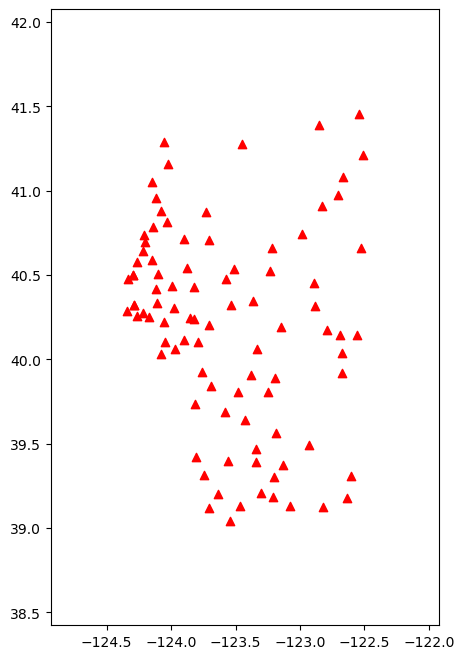

Available stations:
['GHO.NC' 'GBL.NC' 'GHGB.NC' 'GCWB.NC' 'GMR.NC' 'GSR.NC' '79666.CE'
 'GNR.NC' 'GWR.NC' 'BARR.BK' 'GTSB.BK' 'MNDO.BK' 'GVA.NC' '79668.CE'
 'GTC.NC' '79298.CE' 'DCMP.BK' 'GHM.NC' 'KRK.NC' 'KFP.NC' 'KCPB.NC'
 '79046.CE' '79036.CE' 'KIP.NC' 'B934.PB' 'KBN.NC' 'RVIT.BK' 'GROB.NC'
 '79435.CE' '89688.CE' 'LVR.NC' 'B933.PB' 'KLR.NC' '1591.NP' 'PRDS.BK'
 'BRIC.BK' 'LRB.NC' 'LPG.NC' 'PETY.BK' 'HUNT.BK' 'KMR.NC' 'KPR.NC'
 'B049.PB' 'KBU.NC' 'B047.PB' 'KCO.NC' 'B932.PB' 'PETL.BK' 'GHOP.BK'
 'LBP.NC' 'B046.PB' 'BLAS.BK' '89101.CE' 'RBOW.BK' 'KPPB.NC' 'KMPB.NC'
 'KCR.NC' 'B045.PB' 'DLIK.BK' 'KCT.NC' 'B935.PB' '1584.NP' '1584B.NP'
 '89462.CE' 'HAYF.BK' 'KCSB.NC' 'BJES.BK' '1023.NP' '89255.CE' '1586.NP'
 'LSF.NC' 'KHBB.NC' '1582.NP' 'DMOR.BK' 'KNEE.BK' '1581.NP' 'WEAV.BK'
 '89781.CE' 'JCC.BK' 'KHMB.NC' '1580.NP' 'LGP.NC' '89464.CE' 'TRIN.BK'
 'KTD.NC' 'LBK.NC' 'KRP.NC' 'GUMB.BK' 'KOM.NC' '99700.CE' 'SCOT.BK'
 'LPK.NC']


In [3]:
## Plot stations
fig, ax = plt.subplots(figsize = [8,8])
plt.scatter(locs[:,1], locs[:,0], c = 'r', marker = '^')
ax.set_aspect(1.0/np.cos(np.pi*locs[:,0].mean()/180.0)) ## Set projection aspect ratio
d_pad = 0.5 ## Pad 0.5 degrees to plot axes
ax.set_xlim(np.array(ax.get_xlim()) + np.array([-d_pad, d_pad]))
ax.set_ylim(np.array(ax.get_ylim()) + np.array([-d_pad, d_pad]))
plt.show(block = False)
print('Available stations:')
print(stas) ## Station names

Downloaded 155 known events


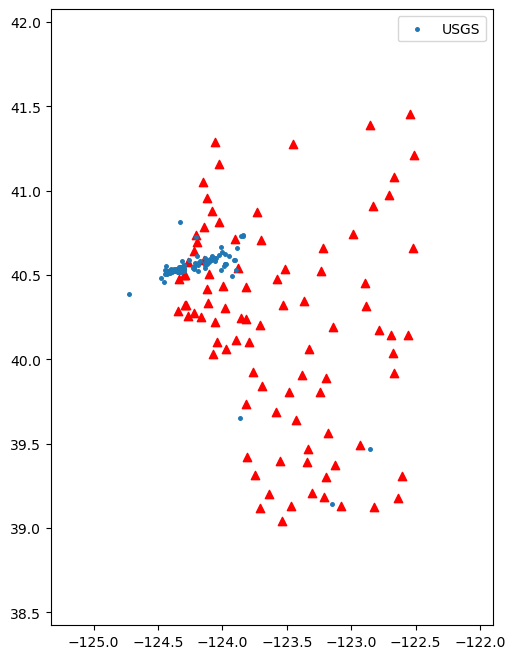

In [4]:
## Let's also download the USGS catalog from the day being processed and add these to the map (12/20/22)
t0 = UTCDateTime(date[0], date[1], date[2])
min_magnitude = 0.1
srcs_known = download_catalog(lat_range, lon_range, min_magnitude, t0, t0 + 3600*24, t0 = t0, client = 'USGS')[0] # Choose client
print('Downloaded %d known events'%len(srcs_known))

## Plot stations
fig, ax = plt.subplots(figsize = [8,8])
plt.scatter(locs[:,1], locs[:,0], c = 'r', marker = '^')
plt.scatter(srcs_known[:,1], srcs_known[:,0], c = 'C0', s = 6.5, marker = 'o', label = 'USGS')
ax.set_aspect(1.0/np.cos(np.pi*locs[:,0].mean()/180.0)) ## Set projection aspect ratio
d_pad = 0.5 ## Pad 0.5 degrees to plot axes
ax.set_xlim(np.array(ax.get_xlim()) + np.array([-d_pad, d_pad]))
ax.set_ylim(np.array(ax.get_ylim()) + np.array([-d_pad, d_pad]))
plt.legend()
plt.show(block = False)


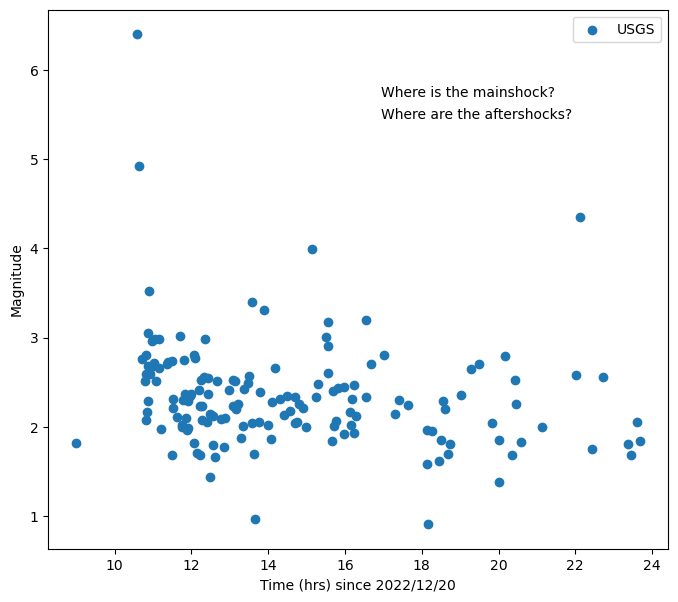

In [5]:
## Let's also look at USGS event magnitudes vs. time
fig, ax = plt.subplots(figsize = [8,7])
plt.scatter(srcs_known[:,3]/3600.0, srcs_known[:,4], label = 'USGS') ## Times (s) vs. magnitudes
plt.xlabel('Time (hrs) since %d/%d/%d'%(date[0], date[1], date[2]))
plt.ylabel('Magnitude')
plt.text(61000/3600.0, 5.7, 'Where is the mainshock?')
plt.text(61000/3600.0, 5.45, 'Where are the aftershocks?')
plt.legend()
plt.show(block = False)

# Now do remaining imports and initilizations

In [6]:
## Check if knn is working on cuda
if device.type == 'cuda' or device.type == 'cpu':
	check_len = knn(torch.rand(10,3).to(device), torch.rand(10,3).to(device), k = 5).numel()
	if check_len != 100: # If it's less than 2 * 10 * 5, there's an issue
		raise SystemError('Issue with knn on cuda for some versions of pytorch geometric and cuda')

	check_len = knn(10.0*torch.rand(200,3).to(device), 10.0*torch.rand(100,3).to(device), k = 15).numel()
	if check_len != 3000: # If it's less than 2 * 10 * 5, there's an issue
		raise SystemError('Issue with knn on cuda for some versions of pytorch geometric and cuda')

x_grids, x_grids_edges, x_grids_trv, x_grids_trv_pointers_p, x_grids_trv_pointers_s, x_grids_trv_refs, max_t = load_templates_region(trv, locs, x_grids, ftrns1, training_params, graph_params, pred_params, device = device)
x_grids_cart_torch = [torch.Tensor(ftrns1(x_grids[i])).to(device) for i in range(len(x_grids))]

# mz = GCN_Detection_Network_extended(ftrns1_diff, ftrns2_diff)

load_model = True
if load_model == True:

	mz_list = []
	for i in range(len(x_grids)):
		mz_slice = GCN_Detection_Network_extended(ftrns1_diff, ftrns2_diff, device = device).to(device)
		mz_slice.load_state_dict(torch.load(path_to_file + 'GNN_TrainedModels/%s_trained_gnn_model_step_%d_ver_%d.h5'%(name_of_project, n_step_load, n_ver_load), map_location = device))
		mz_slice.eval()
		mz_list.append(mz_slice)

failed = []
plot_on = False



day_len = 3600*24
# t_win = config['t_win']

use_adaptive_window = True
if use_adaptive_window == True:
	n_resolution = 9 ## The discretization of the source time function output
	t_win = np.round(np.copy(np.array([2*pred_params[2]]))[0], 2) ## Set window size to the source kernel width (i.e., prediction window is of length +/- src_t_kernel, or [-src_t_kernel + t0, t0 + src_t_kernel])
	dt_win = np.diff(np.linspace(-t_win/2.0, t_win/2.0, n_resolution))[0]
	assert(t_win == pred_params[0])
else:
	dt_win = 1.0 ## Default version
	t_win = 10.0

# step_size = process_config['step_size'] # 'full'
step_size = process_config['step_size']
if step_size == 'full':
	step = n_resolution*dt_win
	n_overlap = 1.0
elif step_size == 'partial':
	step = (n_resolution/3)*dt_win
	n_overlap = 3.0 ## Check this
	assert(use_adaptive_window == True)
	assert(n_resolution == 9) ## hard coded for length nine vector (must check which time fractions of total window stack uniformly over time when doing sliding window and stacking)
elif step_size == 'half':
	step = int(np.floor((n_resolution/2)))*dt_win
	n_overlap = 2.0 ## Check this
	assert(use_adaptive_window == True)
	assert(n_resolution == 9) ## hard coded for length nine vector (must check which time fractions of total window stack uniformly over time when doing sliding window and stacking)

# pred_params = [t_win, kernel_sig_t, src_t_kernel, src_x_kernel, src_depth_kernel]
tc_win = pred_params[2]*1.25 # process_config['tc_win'] # Temporal window (s) to link events in Local Marching
sp_win = pred_params[3]*1.25 # process_config['sp_win'] # Distance (m) to link events in Local Marching
d_win = pred_params[3]*1.25/110e3 ## Converting km to degrees, roughly
d_win_depth = pred_params[4]*1.25  ## proportional to depth kernel
src_t_kernel = pred_params[2] ## temporal source kernel size

## Make topography surface
if (use_topography == True)*(os.path.isfile(path_to_file + 'Grids' + seperator + '%s_surface_elevation.npz'%name_of_project) == True):
	surface_profile = np.load(path_to_file + 'Grids' + seperator + '%s_surface_elevation.npz'%name_of_project)['surface_profile']
elif use_topography == True: ## If no surface profile saved, then interpolate a regular grid based on saved station elevations
	n_surface = 100 ## Default resolution of surface
	x1_surface, x2_surface = np.linspace(lat_range_extend[0], lat_range_extend[1], n_surface), np.linspace(lon_range_extend[0], lon_range_extend[1], n_surface)
	x11_surface, x12_surface = np.meshgrid(x1_surface, x2_surface)
	surface_profile = np.concatenate((x11_surface.reshape(-1,1), x12_surface.reshape(-1,1), np.zeros((len(x11_surface.reshape(-1)),1))), axis = 1)
	tree_sta = cKDTree(ftrns1(locs))
	surface_profile[:,2] = locs[tree_sta.query(ftrns1(surface_profile))[1],2]
	## Average the profile
	edges_surface = knn(torch.Tensor(ftrns1(surface_profile)), torch.Tensor(ftrns1(surface_profile)), k = 15).flip(0).contiguous()
	surface_profile[:,2] = scatter(torch.Tensor(surface_profile[edges_surface[0].cpu().detach().numpy(),2].reshape(-1,1)), edges_surface[1], dim = 0, reduce = 'mean').cpu().detach().numpy().reshape(-1)
else:
	surface_profile = None

# d_win = process_config['d_win'] ## Lat and lon window to re-locate initial source detetections with refined sampling over
# d_win_depth = process_config['d_win_depth'] ## Depth window to re-locate initial source detetections with refined sampling over


tsteps = np.arange(0, day_len, step) ## Make step any of 3 options for efficiency... (a full step, a hald step, and a fifth step?)
tsteps_abs = np.arange(-t_win/2.0, day_len + t_win/2.0 + dt_win, dt_win) ## Fixed solution grid, assume 1 second
tree_tsteps = cKDTree(tsteps_abs.reshape(-1,1))


# tsteps_abs_cat = cKDTree(tsteps.reshape(-1,1)) ## Make this tree, so can look up nearest time for all cat.
print('\nDoing adaptive time steps (%0.2f win, %0.2f step, %0.2f overlap), to avoid issue of repeating time samples'%(dt_win, step, n_overlap))


n_batch = 1
n_batches = int(np.floor(len(tsteps)/n_batch))
n_extra = len(tsteps) - n_batches*n_batch
# n_overlap = int(t_win/step) # check this


# n_samples = int(250e3)
plot_on = False
save_on = True

d_deg = 0.1 ## leads to 42 k grid?
print('Going to compute sources only in interior region')

x1 = np.arange(lat_range[0], lat_range[1] + d_deg, d_deg)
x2 = np.arange(lon_range[0], lon_range[1] + d_deg, d_deg)

# load_prebuilt_sampling_grid = True
n_ver_sampling_grid = 1
if (load_prebuilt_sampling_grid == True)*(os.path.isfile(path_to_file + 'Grids' + seperator + 'prebuilt_sampling_grid_ver_%d.npz'%n_ver_sampling_grid) == True):
	
	z = np.load(path_to_file + 'Grids' + seperator + 'prebuilt_sampling_grid_ver_%d.npz'%n_ver_sampling_grid)
	X_query = z['X_query']
	X_query_cart = torch.Tensor(ftrns1(np.copy(X_query))).to(device)
	z.close()

else:	

	use_irregular_reference_grid = True ## Could add a different function to create the initial grid sampling points
	if use_irregular_reference_grid == True:
		X_query = kmeans_packing_sampling_points(scale_x, offset_x, 3, n_query_grid, ftrns1, n_batch = 3000, n_steps = 3000, n_sim = 1)[0]
		X_query_cart = torch.Tensor(ftrns1(np.copy(X_query))).to(device)
	else:
		x3 = np.arange(-45e3, 5e3 + 10e3, 20e3)
		x11, x12, x13 = np.meshgrid(x1, x2, x3)
		xx = np.concatenate((x11.reshape(-1,1), x12.reshape(-1,1), x13.reshape(-1,1)), axis = 1)
		X_query = np.copy(xx)
		X_query_cart = torch.Tensor(ftrns1(np.copy(xx))).to(device)

	if load_prebuilt_sampling_grid == True:
		np.savez_compressed(path_to_file + 'Grids' + seperator + 'prebuilt_sampling_grid_ver_%d.npz'%n_ver_sampling_grid, X_query = X_query)

loaded_mag_model = False
if compute_magnitudes == True:

	try:
		n_mag_ver = 1
		mags_supp = np.load(path_to_file + 'trained_magnitude_model_ver_%d_supplemental.npz'%n_mag_ver)
		mag_grid, k_grid = mags_supp['mag_grid'], int(mags_supp['k_grid'])
		mags = Magnitude(torch.Tensor(locs).to(device), torch.Tensor(mag_grid).to(device), ftrns1_diff, ftrns2_diff, k = k_grid, device = device)
		mags.load_state_dict(torch.load(path_to_file + 'trained_magnitude_model_ver_%d.hdf5'%n_mag_ver, map_location = device))
		loaded_mag_model = True
		print('Will compute magnitudes since a magnitude model was loaded')
	
	except:
		print('Will not compute magnitudes since no magnitude model was loaded')
		loaded_mag_model = False

else:
	print('Will not compute magnitudes since compute_magnitudes = False')	

# Window over which to "relocate" each 
# event with denser sampling from GNN output
d_deg = 0.018 ## Is this discretization being preserved?
x1 = np.linspace(-d_win, d_win, 15)
x2 = np.linspace(-d_win, d_win, 15)
x3 = np.linspace(-d_win_depth, d_win_depth, 15)
x11, x12, x13 = np.meshgrid(x1, x2, x3)
xx = np.concatenate((x11.reshape(-1,1), x12.reshape(-1,1), x13.reshape(-1,1)), axis = 1)
X_offset = np.copy(xx)

check_if_finished = False

# print('Should change this to use all grids, potentially')
x_grid_ind_list = np.sort(np.random.choice(len(x_grids), size = 1, replace = False)) # 15
x_grid_ind_list_1 = np.sort(np.random.choice(len(x_grids), size = len(x_grids), replace = False)) # 15

use_only_one_grid = process_config['use_only_one_grid']
if use_only_one_grid == True:
	# x_grid_ind_list_1 = np.array([x_grid_ind_list_1[np.random.choice(len(x_grid_ind_list_l))]])
	x_grid_ind_list_1 = np.copy(x_grid_ind_list)

assert (max([abs(len(x_grids_trv_refs[0]) - len(x_grids_trv_refs[j])) for j in range(len(x_grids_trv_refs))]) == 0)

n_scale_x_grid = len(x_grid_ind_list)
n_scale_x_grid_1 = len(x_grid_ind_list_1)

fail_count = 0
success_count = 0

## Extra default parameters
n_src_query = 1
x_src_query = locs.mean(0).reshape(1,-1) # arbitrary point to query source-arrival associations during initial processing pass
x_src_query_cart = torch.Tensor(ftrns1(x_src_query))
tq_sample = torch.rand(n_src_query)*t_win - t_win/2.0 # Note this part!
tq_sample = torch.zeros(1)
tq = torch.arange(-t_win/2.0, t_win/2.0 + dt_win, dt_win).reshape(-1,1).float().to(device)

yr, mo, dy = date[0], date[1], date[2]
date = np.array([yr, mo, dy])

P, ind_use = load_picks(path_to_file, date, spr_picks = spr_picks, n_ver = n_ver_picks)
# P, ind_use = load_picks(path_to_file, date, locs, stas, lat_range, lon_range, spr_picks = spr_picks, n_ver = n_ver_picks)
print('\nUsing %d total picks (%d P and %d S waves) \n'%(len(P), len(np.where(P[:,4] == 0)[0]), len(np.where(P[:,4] == 1)[0])))

if use_phase_types == False:
	P[:,4] = 0 ## No phase types
locs_use = locs[ind_use]
arrivals_tree = cKDTree(P[:,0][:,None])

use_updated_input = True
dt_embed_discretize = np.round(pred_params[1]/10.0, 2) # 0.05 ## Picks are discretized to this amount if using updated input to speed up input


Doing adaptive time steps (0.88 win, 7.88 step, 1.00 overlap), to avoid issue of repeating time samples
Going to compute sources only in interior region
Will not compute magnitudes since compute_magnitudes = False

Using 110623 total picks (54177 P and 56446 S waves) 



# Now let's visualize the picks
<pre>
The picks are stored in "P" variable; each row is (time, station index, amplitude, prob pick, phase type)

Station indices are sorted by increasing latitude.

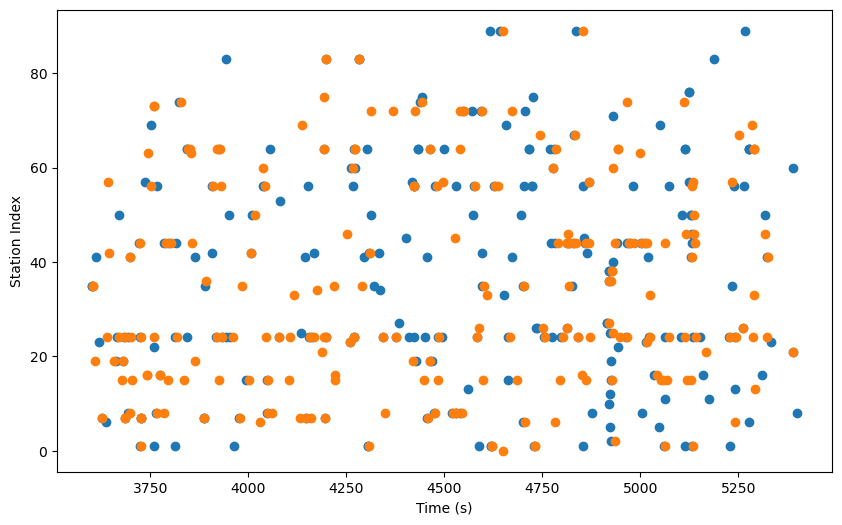


Is this before or after the mainshock? Why do you think so?



In [7]:
## Let's plot the picks and zoom in on a few intervals
fig, ax = plt.subplots(figsize = [10,6])
t_window = [3600.0, 3600.0 + 60.0*30] ## Plot a 30 min window
i1 = np.where(((P[:,0] > t_window[0])*(P[:,0] < t_window[1]))*(P[:,4] == 0))[0]
i2 = np.where(((P[:,0] > t_window[0])*(P[:,0] < t_window[1]))*(P[:,4] == 1))[0]
ax.scatter(P[i1,0], P[i1,1], c = 'C0')
ax.scatter(P[i2,0], P[i2,1], c = 'C1')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Station Index')
plt.show(block = False)
print('\nIs this before or after the mainshock? Why do you think so?\n')

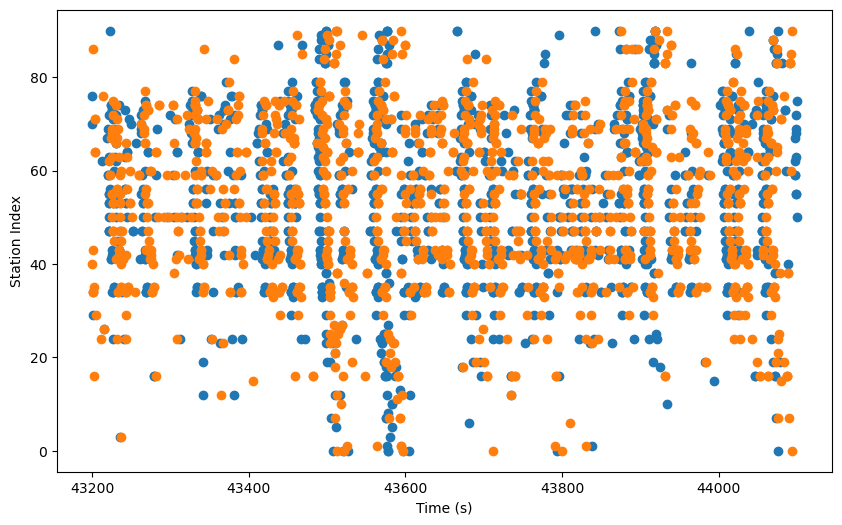


Is this before or after the mainshock? Why do you think so?



In [8]:
## Here's another interval
fig, ax = plt.subplots(figsize = [10,6]) # 10:34:25
t_window = [3600.0*12, 3600.0*12 + 60.0*15] ## Plot a 15 min window
i1 = np.where(((P[:,0] > t_window[0])*(P[:,0] < t_window[1]))*(P[:,4] == 0))[0]
i2 = np.where(((P[:,0] > t_window[0])*(P[:,0] < t_window[1]))*(P[:,4] == 1))[0]
ax.scatter(P[i1,0], P[i1,1], c = 'C0')
ax.scatter(P[i2,0], P[i2,1], c = 'C1')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Station Index')
plt.show(block = False)
print('\nIs this before or after the mainshock? Why do you think so?\n')

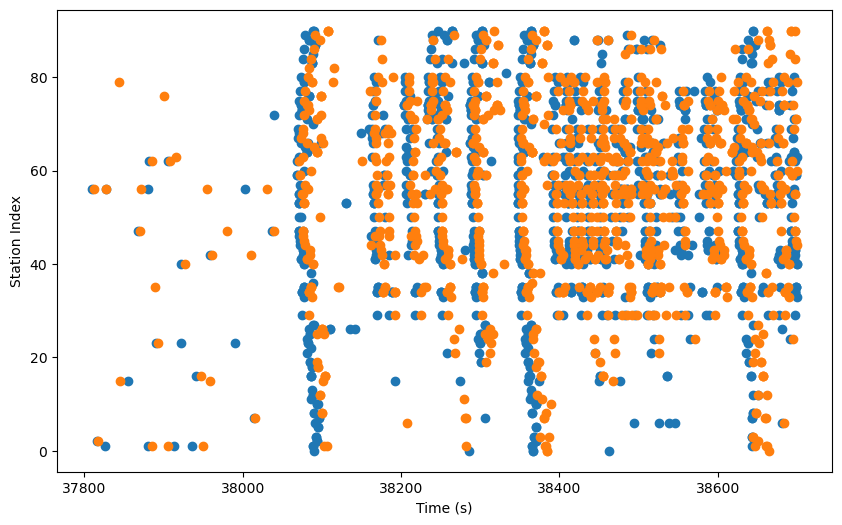


Is this before or after the mainshock? Why do you think so?



In [9]:
## And one more interval
fig, ax = plt.subplots(figsize = [10,6])
t_window = [3600.0*10.5, 3600.0*10.5 + 60.0*15] ## Plot a 15 min window
i1 = np.where(((P[:,0] > t_window[0])*(P[:,0] < t_window[1]))*(P[:,4] == 0))[0]
i2 = np.where(((P[:,0] > t_window[0])*(P[:,0] < t_window[1]))*(P[:,4] == 1))[0]
ax.scatter(P[i1,0], P[i1,1], c = 'C0')
ax.scatter(P[i2,0], P[i2,1], c = 'C1')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Station Index')
plt.show(block = False)
print('\nIs this before or after the mainshock? Why do you think so?\n')

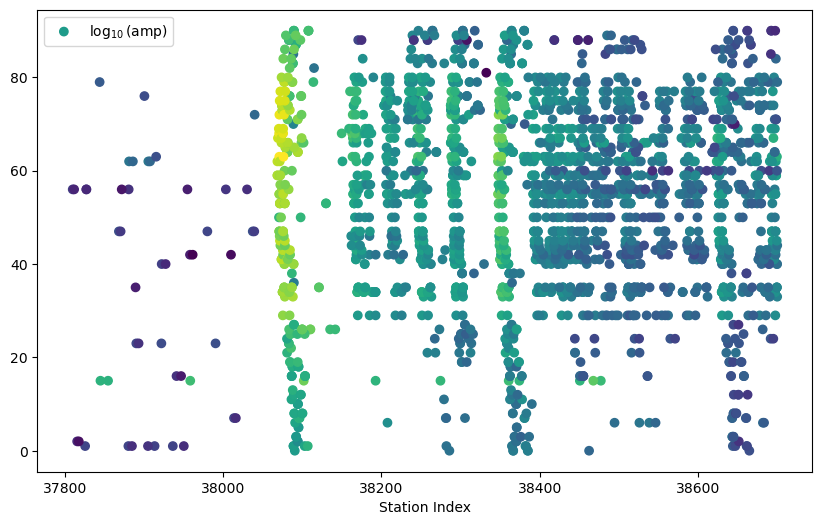


Why does the pattern of colors look like this?



In [10]:
## Here is the same interval, where picks are colored by log(amplitude)
fig, ax = plt.subplots(figsize = [10,6])
t_window = [3600.0*10.5, 3600.0*10.5 + 60.0*15] ## Plot a 15 min window
i1 = np.where(((P[:,0] > t_window[0])*(P[:,0] < t_window[1]))*(P[:,4] == 0))[0]
i2 = np.where(((P[:,0] > t_window[0])*(P[:,0] < t_window[1]))*(P[:,4] == 1))[0]
ax.scatter(P[i1,0], P[i1,1], c = np.log10(P[i1,2]), label = r'$\log_{10}$(amp)')
ax.scatter(P[i2,0], P[i2,1], c = np.log10(P[i2,2]))
ax.set_xlabel('Time (s)')
ax.set_xlabel('Station Index')
plt.legend()
plt.show(block = False)
print('\nWhy does the pattern of colors look like this?\n')

# Let's check how reliable our travel time calculator and picks are
<pre>
To do this we will predict travel times across network for a few fixed source locations and compare against the observed picks.

<pre>
    (i). First we'll do random source coordinates (and origin times)
    
<pre>
    (ii). Then we'll do "known" USGS source coordinates (and origin times)

Random sources
[[  41.39717691 -122.95305561]
 [  40.54409441 -123.66854128]
 [  40.95618901 -124.16159272]
 [  40.53554194 -124.92034041]
 [  40.03999622 -122.59614831]
 [  39.04598758 -123.56308496]
 [  40.03923759 -124.77781022]
 [  40.00838961 -122.63173284]
 [  39.49704195 -123.35459597]
 [  40.68107404 -124.19098686]]
Shape of trv_out is (num_sources, num_stations, num_phase_type)


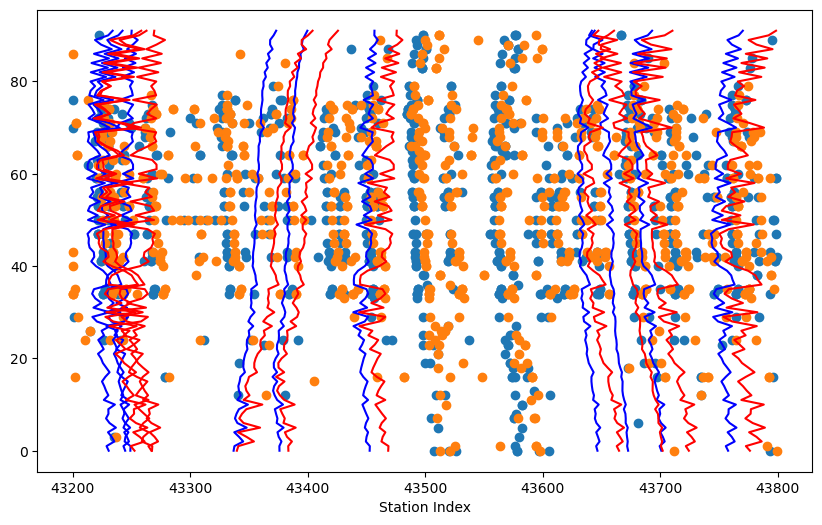


Why do moveout curves look like this? Are they meaningful?



In [11]:
## Predict travel times (random source coordinatea and origin times)
n_srcs = 10 ## Number sources
t_win_rand = 10 ## Window over which sources occur (minutes)
src_random = np.random.rand(n_srcs,3)*scale_x + offset_x # (note: scale_x and offset_x define region of interest)
src_origin = np.random.rand(n_srcs)*60.0*t_win_rand + 12*3600.0 ## Nucleate sources within 10 minute interval, starting after 12:00:00 UTC.

print('Random sources')
print(src_random[:,0:2])
## This calls the travel time nueral network for chosen stations and sources
trv_out = trv(torch.Tensor(locs).to(device), torch.Tensor(src_random).to(device)).cpu().detach().numpy() + src_origin.reshape(-1,1,1)
print('Shape of trv_out is (num_sources, num_stations, num_phase_type)')

## Plot picks with travel times (from random source coordinates) overlaying the picks
fig, ax = plt.subplots(figsize = [10,6]) # 10:34:25
t_window = [3600.0*12, 3600.0*12 + 60.0*t_win_rand] ## Plot a 10 min window
i1 = np.where(((P[:,0] > t_window[0])*(P[:,0] < t_window[1]))*(P[:,4] == 0))[0]
i2 = np.where(((P[:,0] > t_window[0])*(P[:,0] < t_window[1]))*(P[:,4] == 1))[0]
ax.scatter(P[i1,0], P[i1,1], c = 'C0')
ax.scatter(P[i2,0], P[i2,1], c = 'C1')
ax.plot(trv_out[:,:,0].T, np.arange(trv_out.shape[1]), c = 'b')
ax.plot(trv_out[:,:,1].T, np.arange(trv_out.shape[1]), c = 'r')
ax.set_xlabel('Time (s)')
ax.set_xlabel('Station Index')
plt.show(block = False)
print('\nWhy do moveout curves look like this? Are they meaningful?\n')


Shape of trv_out is (num_sources, num_stations, num_phase_type)


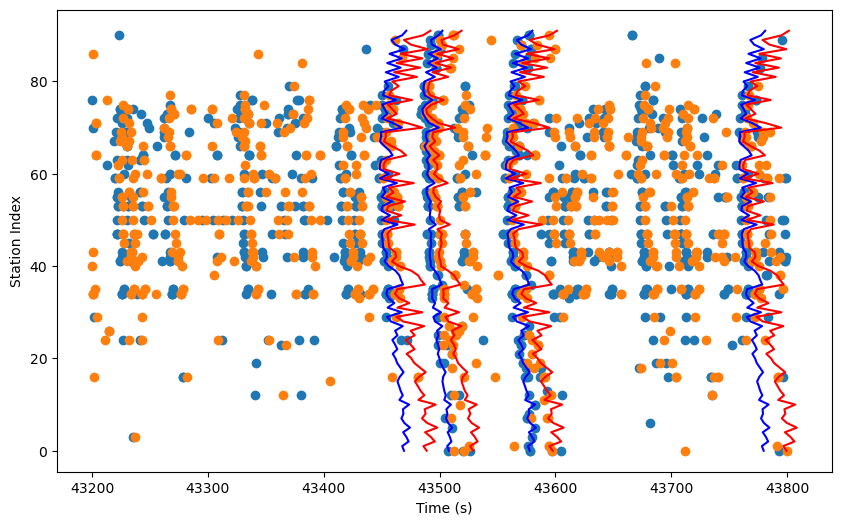

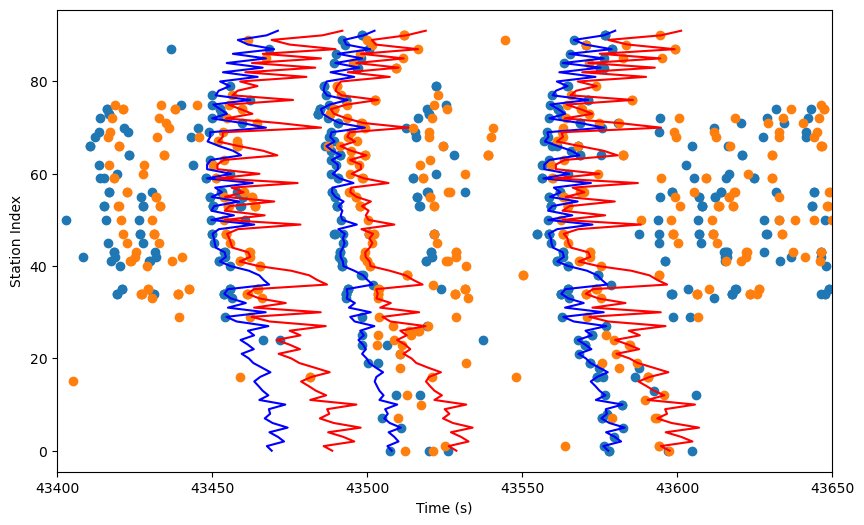


Why do moveout curves look like this? Are they meaningful?


Can the result shown be improved? How?


In [12]:
## Predict travel times (known source coordinates)

# Find known sources with origin time within pre-specific window
ifind = np.where((srcs_known[:,3] < t_window[1])*(srcs_known[:,3] > t_window[0]))[0]

## This calls the travel time nueral network for chosen stations and sources
trv_out = trv(torch.Tensor(locs).to(device), torch.Tensor(srcs_known[ifind]).to(device)).cpu().detach().numpy() + srcs_known[ifind,3].reshape(-1,1,1)
print('Shape of trv_out is (num_sources, num_stations, num_phase_type)')

## Plot picks with travel times (from random source coordinates) overlaying the picks
fig, ax = plt.subplots(figsize = [10,6]) # 10:34:25
# t_window = [3600.0*12, 3600.0*12 + 60.0*t_win_rand] ## Plot a 10 min window
i1 = np.where(((P[:,0] > t_window[0])*(P[:,0] < t_window[1]))*(P[:,4] == 0))[0]
i2 = np.where(((P[:,0] > t_window[0])*(P[:,0] < t_window[1]))*(P[:,4] == 1))[0]
ax.scatter(P[i1,0], P[i1,1], c = 'C0')
ax.scatter(P[i2,0], P[i2,1], c = 'C1')
ax.plot(trv_out[:,:,0].T, np.arange(trv_out.shape[1]), c = 'b')
ax.plot(trv_out[:,:,1].T, np.arange(trv_out.shape[1]), c = 'r')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Station Index')
plt.show(block = False)

## Inset of the previous plot
fig, ax = plt.subplots(figsize = [10,6]) # 10:34:25
# t_window = [3600.0*12, 3600.0*12 + 60.0*t_win_rand] ## Plot a 10 min window
i1 = np.where(((P[:,0] > t_window[0])*(P[:,0] < t_window[1]))*(P[:,4] == 0))[0]
i2 = np.where(((P[:,0] > t_window[0])*(P[:,0] < t_window[1]))*(P[:,4] == 1))[0]
ax.scatter(P[i1,0], P[i1,1], c = 'C0')
ax.scatter(P[i2,0], P[i2,1], c = 'C1')
ax.plot(trv_out[:,:,0].T, np.arange(trv_out.shape[1]), c = 'b')
ax.plot(trv_out[:,:,1].T, np.arange(trv_out.shape[1]), c = 'r')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Station Index')
ax.set_xlim([43400, 43650])
plt.show(block = False)

print('\nWhy do moveout curves look like this? Are they meaningful?\n')

print('\nCan the result shown be improved? How?')


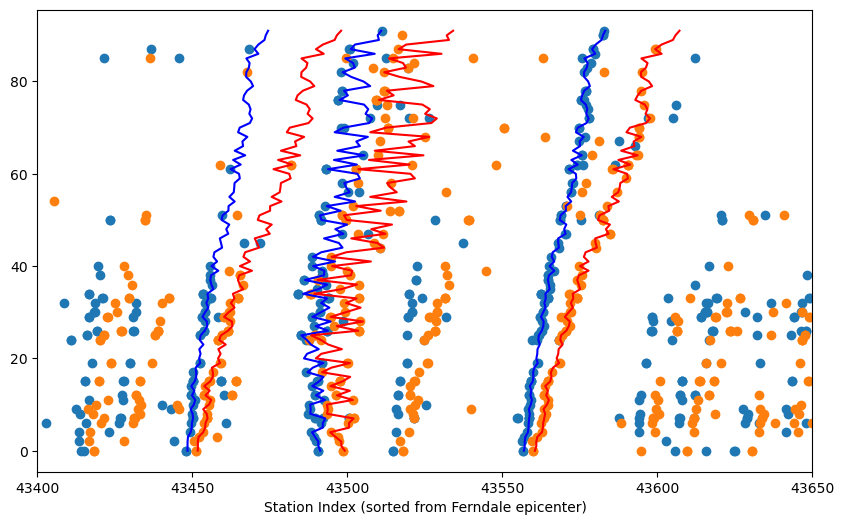


Which sources are close to Ferndale? Which ones arnt?


Which event is the biggest? Why?


In [13]:
## Now we'll show the previous plot sorted by distance from Ferndale epicenter

isort = np.argsort(np.linalg.norm(np.array([40.525, -124.423]).reshape(1,-1) - locs[:,0:2], axis = 1))
perm_vec = (-1*np.ones(len(locs))).astype('int')
perm_vec[isort] = np.arange(len(isort))
assert(perm_vec.min() > -1)

fig, ax = plt.subplots(figsize = [10,6]) # 10:34:25
# t_window = [3600.0*12, 3600.0*12 + 60.0*t_win_rand] ## Plot a 10 min window
i1 = np.where(((P[:,0] > t_window[0])*(P[:,0] < t_window[1]))*(P[:,4] == 0))[0]
i2 = np.where(((P[:,0] > t_window[0])*(P[:,0] < t_window[1]))*(P[:,4] == 1))[0]
ax.scatter(P[i1,0], perm_vec[P[i1,1].astype('int')], c = 'C0')
ax.scatter(P[i2,0], perm_vec[P[i2,1].astype('int')], c = 'C1')
ax.plot(trv_out[:,isort,0].T, np.arange(trv_out.shape[1]), c = 'b')
ax.plot(trv_out[:,isort,1].T, np.arange(trv_out.shape[1]), c = 'r')
ax.set_xlabel('Time (s)')
ax.set_xlabel('Station Index (sorted from Ferndale epicenter)')
ax.set_xlim([43400, 43650])
plt.show(block = False)

print('\nWhich sources are close to Ferndale? Which ones arnt?\n')
print('\nWhich event is the biggest? Why?')

# Is the travel time calculator working? Do the picks seem plausible? Why?

# Lastly let's check the station and source graphs we're using

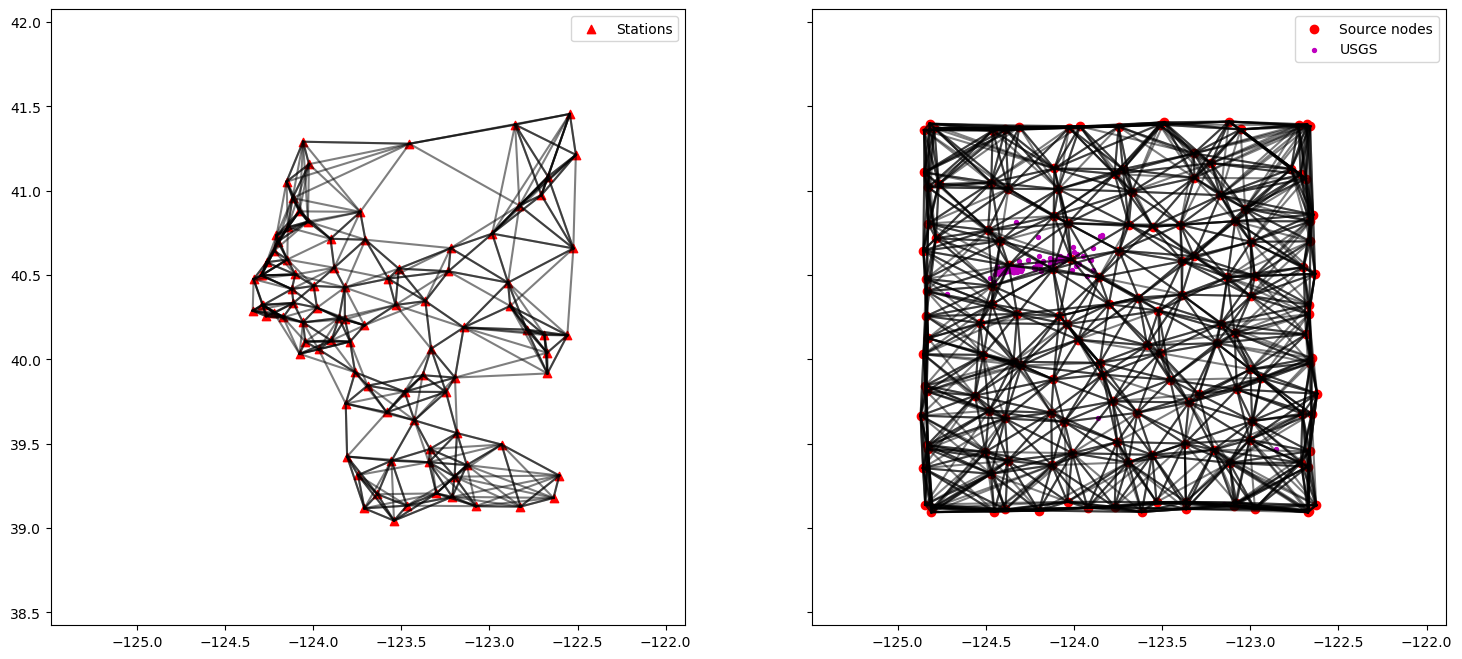

In [14]:
fig, ax = plt.subplots(1, 2, figsize = [18,8], sharex = True, sharey = True)

## We'll use K-nearest-neighbor graphs.

## We also use our (lat,long,depth) --> (x,y,z) projection function, "ftrns1", to fasciliate distance measurements

## Build station graph
edges_sta = knn(torch.Tensor(ftrns1(locs)).to(device)/1000.0, torch.Tensor(ftrns1(locs)).to(device)/1000.0, k = k_sta_edges).flip(0).contiguous().cpu().detach().numpy()
# edges_sta = knn(torch.Tensor(locs[:,0:2]).to(device), torch.Tensor(locs[:,0:2]).to(device), k = 2) # .flip(0).contiguous().cpu().detach().numpy()

## Build source graph
edges_src = knn(torch.Tensor(ftrns1(x_grids[0])).to(device)/1000.0, torch.Tensor(ftrns1(x_grids[0])).to(device)/1000.0, k = k_spc_edges).flip(0).contiguous().cpu().detach().numpy()

ax[0].scatter(locs[:,1], locs[:,0], c = 'r', marker = '^', label = 'Stations')
for j in range(edges_sta.shape[1]):
    ax[0].plot(np.concatenate((locs[edges_sta[0][j],1].reshape(1,-1), locs[edges_sta[1][j],1].reshape(1,-1)), axis = 1).T, np.concatenate((locs[edges_sta[0][j],0].reshape(1,-1), locs[edges_sta[1][j],0].reshape(1,-1)), axis = 1).T, c = 'black', alpha = 0.5)
ax[1].scatter(x_grids[0][:,1], x_grids[0][:,0], c = 'r', label = 'Source nodes', marker = 'o')
for j in range(edges_src.shape[1]):
    ax[1].plot(np.concatenate((x_grids[0][edges_src[0][j],1].reshape(1,-1), x_grids[0][edges_src[1][j],1].reshape(1,-1)), axis = 1).T, np.concatenate((x_grids[0][edges_src[0][j],0].reshape(1,-1), x_grids[0][edges_src[1][j],0].reshape(1,-1)), axis = 1).T, c = 'black', alpha = 0.5)
d_pad = 0.5 ## Pad 0.5 degrees to plot axes
ax[1].scatter(srcs_known[:,1], srcs_known[:,0], c = 'm', s = 8.0, marker = 'o', label = 'USGS')
ax[0].set_xlim(np.array(ax[0].get_xlim()) + np.array([-d_pad, d_pad]))
ax[0].set_ylim(np.array(ax[0].get_ylim()) + np.array([-d_pad, d_pad]))
ax[1].set_xlim(np.array(ax[0].get_xlim())) # + np.array([-d_pad, d_pad]))
ax[1].set_ylim(np.array(ax[0].get_ylim())) # + np.array([-d_pad, d_pad]))
# ax[0].set_title('Stations')
# ax[0].set_title('Sources')
ax[0].legend()
ax[1].legend()


# Now let's run the associator. We'll plot a few intermediate outputs and results.

In [15]:
## To speed things up for this test, we're only going to process 3 hours of data (around the mainshock)
clip_win_start = 37000.0
clip_win_duration = 3600.0*3
ifind = np.where((P[:,0] > clip_win_start)*(P[:,0] < (clip_win_start + clip_win_duration)))[0]
n_total = len(P)
P = P[ifind] ## Only keeping a subset of the picks
print('Keeping %d of %d total picks (%d P waves and %d S waves)'%(len(P), n_total, len(np.where(P[:,4] == 0)[0]), len(np.where(P[:,4] == 1)[0])))

Keeping 32045 of 110623 total picks (15558 P waves and 16487 S waves)


In [16]:
## Now we're going to run GENIE over all the continuous space-time data.

# The first step detects all space-time maximum outputs (e.g., candidate sources), 
# by passing in the inputs over sliced windows to the GNN, storing outputs, 
# stepping forward in time, and stacking overlapping portions.

# Then it runs a "peak finding" algorithm to detect a discrete number of candidate sources in time,
# and then the "local marching" method to merge nearby maxima in space.

trv_out_src = trv(torch.Tensor(locs[ind_use]).to(device), torch.Tensor(x_src_query).to(device)).detach() # .to(device)
locs_use_cart_torch = torch.Tensor(ftrns1(locs_use)).to(device)
A_src_in_sta_l = []

for i in range(len(x_grids)):

    if use_subgraph == False:
    
        # x_grids, x_grids_edges, x_grids_trv, x_grids_trv_pointers_p, x_grids_trv_pointers_s, x_grids_trv_refs
        A_sta_sta, A_src_src, A_prod_sta_sta, A_prod_src_src, A_src_in_prod, A_edges_time_p, A_edges_time_s, A_edges_ref = extract_inputs_adjacencies(trv, locs, ind_use, x_grids[i], x_grids_trv[i], x_grids_trv_refs[i], x_grids_trv_pointers_p[i], x_grids_trv_pointers_s[i], ftrns1, graph_params, device = device)

        A_src_in_sta = torch.Tensor(np.concatenate((np.tile(np.arange(len(ind_use)), len(x_grids[i])).reshape(1,-1), np.arange(len(x_grids[i])).repeat(len(ind_use), axis = 0).reshape(1,-1)), axis = 0)).long().to(device)
        spatial_vals = torch.Tensor(((np.repeat(np.expand_dims(x_grids[i], axis = 1), len(ind_use), axis = 1) - np.repeat(np.expand_dims(locs[ind_use], axis = 0), x_grids[i].shape[0], axis = 0)).reshape(-1,3))/scale_x_extend).to(device)
        A_src_in_edges = Data(x = spatial_vals, edge_index = A_src_in_prod).to(device)
        A_Lg_in_src = Data(x = spatial_vals, edge_index = torch.Tensor(np.ascontiguousarray(np.flip(A_src_in_prod.cpu().detach().numpy(), axis = 0))).long()).to(device)
        trv_out = trv(torch.Tensor(locs[ind_use]).to(device), torch.Tensor(x_grids[i]).to(device)).detach().reshape(-1,2) ## Can replace trv_out with Trv_out
        mz_list[i].set_adjacencies(A_prod_sta_sta, A_prod_src_src, A_src_in_edges, A_Lg_in_src, A_src_in_sta, A_src_src, torch.Tensor(A_edges_time_p).long().to(device), torch.Tensor(A_edges_time_s).long().to(device), torch.Tensor(A_edges_ref).to(device), trv_out, torch.Tensor(ftrns1(locs_use)).to(device), torch.Tensor(ftrns1(x_grids[i])).to(device))
        A_src_in_sta_l.append(A_src_in_sta.cpu().detach().numpy())

    else:

        # x_grids, x_grids_edges, x_grids_trv, x_grids_trv_pointers_p, x_grids_trv_pointers_s, x_grids_trv_refs
        A_sta_sta, A_src_src, A_prod_sta_sta, A_prod_src_src, A_src_in_prod, A_src_in_sta = extract_inputs_adjacencies_subgraph(locs_use, x_grids[i], ftrns1, ftrns2, max_deg_offset = max_deg_offset, k_nearest_pairs = k_nearest_pairs, k_sta_edges = k_sta_edges, k_spc_edges = k_spc_edges, device = device)
        A_edges_time_p, A_edges_time_s, dt_partition = compute_time_embedding_vectors(trv_pairwise, locs_use, x_grids[i], A_src_in_sta, max_t, t_win = t_win, device = device)
        spatial_vals = torch.Tensor((x_grids[i][A_src_in_prod[1].cpu().detach().numpy()] - locs_use[A_src_in_sta[0][A_src_in_prod[0]].cpu().detach().numpy()])/scale_x_extend).to(device)
        A_src_in_prod = Data(x = spatial_vals, edge_index = A_src_in_prod)
        
        flipped_edge = torch.Tensor(np.ascontiguousarray(np.flip(A_src_in_prod.edge_index.cpu().detach().numpy(), axis = 0))).long().to(device)
        A_src_in_prod_flipped = Data(x = spatial_vals, edge_index = flipped_edge).to(device)
        trv_out = trv_pairwise(torch.Tensor(locs_use[A_src_in_sta[0].cpu().detach().numpy()]).to(device), torch.Tensor(x_grids[i][A_src_in_sta[1].cpu().detach().numpy()]).to(device))
        mz_list[i].set_adjacencies(A_prod_sta_sta, A_prod_src_src, A_src_in_prod, A_src_in_prod_flipped, A_src_in_sta, A_src_src, torch.Tensor(A_edges_time_p).long().to(device), torch.Tensor(A_edges_time_s).long().to(device), torch.Tensor(dt_partition).to(device), trv_out, torch.Tensor(ftrns1(locs_use)).to(device), torch.Tensor(ftrns1(x_grids[i])).to(device))
        A_src_in_sta_l.append(A_src_in_sta.cpu().detach().numpy())

check_overflow = True
if (use_updated_input == True)*(check_overflow == True): ## Check if embedding correctly preserved all travel time indices (overflow can happen on GPU for very large spatial domains x number of stations when using scatter)
    ## Note, must also add check that overflow doesn't happen during the second scatter operation in extract_input_from_data
    n_random_check = 5
    for i in range(n_random_check): ## n_random_check
        ## Simulate picks
        src, src_origin = x_grids[0][np.random.choice(len(x_grids[0]))].reshape(1,-1), np.random.rand()*(np.nanmax(P[:,0]) - np.nanmin(P[:,0])) + np.nanmin(P[:,0])
        trv_out = trv(torch.Tensor(locs).to(device), torch.Tensor(src).to(device)).cpu().detach().numpy() + src_origin
        ikeep = np.sort(np.random.choice(len(ind_use), size = int(np.ceil(len(ind_use)*0.7)), replace = False))
        ikeep1 = np.sort(np.random.choice(len(ind_use), size = int(np.ceil(len(ind_use)*0.7)), replace = False))
        
        P1 = np.concatenate((trv_out[0,ind_use[ikeep],0].reshape(-1,1), ind_use[ikeep].reshape(-1,1), np.zeros((len(ikeep),3))), axis = 1)
        P1 = np.concatenate((P1, np.concatenate((trv_out[0,ind_use[ikeep1],1].reshape(-1,1), ind_use[ikeep1].reshape(-1,1), np.zeros((len(ikeep1),2)), np.ones((len(ikeep1),1))), axis = 1)), axis = 0)
        # if use_phase_types == False:
        # 	P1[:,4] = 0 ## No phase types

        x_grid_ind = x_grid_ind_list[0] ## Note: if this fails, essentially dt_embed_discretize is too small (resulting in too many time steps x number stations (combined with max moveout, max_t) leading to too large of graphs in the scatter operation for extracting inputs (e.g., ~ 100 million nodes))
        embed_p, embed_s, ind_unique_, abs_time_ref_, n_time_series_, n_sta_unique_ = extract_input_from_data(trv_pairwise, P1, np.array([src_origin]), ind_use, locs, x_grids[x_grid_ind], A_src_in_sta_l[x_grid_ind], trv_times = x_grids_trv[x_grid_ind], max_t = max_t, kernel_sig_t = pred_params[1], dt = dt_embed_discretize, return_embedding = True, device = device)

        ## Check positive points
        vec_p_ = embed_p.reshape(n_sta_unique_, n_time_series_)
        vec_s_ = embed_s.reshape(n_sta_unique_, n_time_series_)
        tree_ = cKDTree(ind_unique_.reshape(-1,1))
        ip_ = tree_.query(P1[:,1].reshape(-1,1))[1] ## Matched index to unique indices
        ip1_, ip2_ = np.where(P1[:,4] == 0)[0], np.where(P1[:,4] == 1)[0]
        t_p_, t_s_ = ((P1[ip1_,0] - abs_time_ref_[0])/dt_embed_discretize).astype('int'), ((P1[ip2_,0] - abs_time_ref_[0])/dt_embed_discretize).astype('int')
        itp_, its_ = np.where((t_p_ >= 0)*(t_p_ < n_time_series_))[0], np.where((t_s_ >= 0)*(t_s_ < n_time_series_))[0]
        val_p_, val_s_ = vec_p_[ip_[ip1_[itp_]], t_p_[itp_]].cpu().detach().numpy(), vec_s_[ip_[ip2_[its_]], t_s_[its_]].cpu().detach().numpy()
        if len(val_p_) > 0: assert(val_p_.min() > 0.9)
        if len(val_s_) > 0: assert(val_s_.min() > 0.9)
        print('Min check val is %0.4f'%np.min(np.concatenate((val_p_, val_s_), axis = 0)))

        ## Check zero points
        iselect_ = np.sort(np.random.choice(len(P1), size = 10000))
        iwhere_p_, iwhere_s_ = np.where(P1[iselect_,4] == 0)[0], np.where(P1[iselect_,4] == 1)[0]
        t_rand_p_ = P1[iselect_[iwhere_p_],0] + 4.0*pred_params[1]*np.random.choice([-1.0, 1.0], size = len(iwhere_p_))
        t_rand_s_ = P1[iselect_[iwhere_s_],0] + 4.0*pred_params[1]*np.random.choice([-1.0, 1.0], size = len(iwhere_s_))

        ip_1_ = tree_.query(P1[iselect_[iwhere_p_],1].reshape(-1,1))[1] ## Matched index to unique indices
        ip_2_ = tree_.query(P1[iselect_[iwhere_s_],1].reshape(-1,1))[1] ## Matched index to unique indices
        ip1_, ip2_ = np.where(P1[iselect_[iwhere_p_],4] == 0)[0], np.where(P1[iselect_[iwhere_s_],4] == 1)[0]
        t_p_, t_s_ = ((t_rand_p_[ip1_] - abs_time_ref_[0])/dt_embed_discretize).astype('int'), ((t_rand_s_[ip2_] - abs_time_ref_[0])/dt_embed_discretize).astype('int')
        itp_, its_ = np.where((t_p_ >= 0)*(t_p_ < n_time_series_))[0], np.where((t_s_ >= 0)*(t_s_ < n_time_series_))[0]
        val_p_, val_s_ = vec_p_[ip_1_[ip1_[itp_]], t_p_[itp_]].cpu().detach().numpy(), vec_s_[ip_2_[ip2_[its_]], t_s_[its_]].cpu().detach().numpy()
        if len(val_p_) > 0: assert(val_p_.max() < 0.1)
        if len(val_s_) > 0: assert(val_s_.max() < 0.1)
        print('Max check val is %0.4f \n'%np.max(np.concatenate((val_p_, val_s_), axis = 0)))


tree_picks = cKDTree(P[:,0:2]) # based on absolute indices


P_perm = np.copy(P)
perm_vec = -1*np.ones(locs.shape[0])
perm_vec[ind_use] = np.arange(len(ind_use))
P_perm[:,1] = perm_vec[P_perm[:,1].astype('int')]

if process_known_events == False: # If false, process continuous days
    times_need_l = np.copy(tsteps)
else:  # If true, process around times of known events
    srcs_known_times = np.copy(srcs_known[:,3])
    tree_srcs_known_times = cKDTree(tsteps.reshape(-1,1))
    ip_nearest_srcs_known_times = tree_srcs_known_times.query(srcs_known_times.reshape(-1,1))[1]
    srcs_known_times = tsteps[ip_nearest_srcs_known_times]
    times_need_l = np.unique((srcs_known_times.reshape(-1,1) + np.arange(-pred_params[0]*3, pred_params[0]*3 + step, step).reshape(1,-1)).reshape(-1))
    
## Double check this.
n_batches = int(np.floor(len(times_need_l)/n_batch))
times_need = [times_need_l[j*n_batch:(j + 1)*n_batch] for j in range(n_batches)]
if n_batches*n_batch < len(times_need_l):
    times_need.append(times_need_l[n_batches*n_batch::]) ## Add last few samples

assert(len(np.hstack(times_need)) == len(np.unique(np.hstack(times_need))))

skip_quiescent_intervals = True
if skip_quiescent_intervals == True:
    min_pick_window = min_required_picks if min_required_picks != False else 1 ## Check windows with at least this many picks
    times_ind_need = []
    sc_inc = 0
    ## Find time window where < min_pick_window occur on the input set, and do not process
    for i in range(len(times_need)):
        lp = arrivals_tree.query_ball_point(times_need[i].reshape(-1,1) + max_t/2.0, r = t_win + max_t/2.0)
        for j in range(len(times_need[i])):
            if len(list(lp[j])) >= min_pick_window:
                times_ind_need.append(sc_inc)
            sc_inc += 1

    ## Subselect times_need_l
    if len(times_ind_need) > 0:
        times_need_l = times_need_l[np.array(times_ind_need)]

        ## Double check this.
        n_batches = int(np.floor(len(times_need_l)/n_batch))
        times_need = [times_need_l[j*n_batch:(j + 1)*n_batch] for j in range(n_batches)]
        if n_batches*n_batch < len(times_need_l):
            times_need.append(times_need_l[n_batches*n_batch::]) ## Add last few samples

        assert(len(np.hstack(times_need)) == len(np.unique(np.hstack(times_need))))
        print('Processing %d inputs in %d batches'%(len(times_need_l), len(times_need)))

    else:
        print('No windows with > %d picks (min_pick_window)'%min_pick_window)
        print('Stopping processing')
        # continue

# Out_1 = np.zeros((x_grids[x_grid_ind_list[0]].shape[0], len(tsteps_abs))) # assumes all grids have same cardinality
Out_2 = np.zeros((X_query_cart.shape[0], len(tsteps_abs)))

# with torch.no_grad():

for n in range(len(times_need)):

    tsteps_slice = times_need[n]
    tsteps_slice_indices = tree_tsteps.query(tsteps_slice.reshape(-1,1))[1]
    # out_cumulative_max = 0.0
    
    for x_grid_ind in x_grid_ind_list:

        if use_updated_input == False:
        
            ## It might be more efficient if Inpts, Masks, lp_times, and lp_stations were already on Tensor
            [Inpts, Masks], [lp_times, lp_stations, lp_phases, lp_meta] = extract_inputs_from_data_fixed_grids_with_phase_type(trv, locs, ind_use, P, P[:,4], arrivals_tree, tsteps_slice, x_grids[x_grid_ind], x_grids_trv[x_grid_ind], lat_range_extend, lon_range_extend, depth_range, max_t, training_params, graph_params, pred_params, ftrns1, ftrns2)

        else:

            [Inpts, Masks], [lp_times, lp_stations, lp_phases, lp_meta] = extract_input_from_data(trv_pairwise, P, tsteps_slice, ind_use, locs, x_grids[x_grid_ind], A_src_in_sta_l[x_grid_ind], trv_times = x_grids_trv[x_grid_ind], max_t = max_t, kernel_sig_t = pred_params[1], dt = dt_embed_discretize, device = device)

        # if use_subgraph == True:
        # 	for i in range(len(Inpts)):
        #                 Inpts[i] = Inpts[i].reshape(x_grids[x_grid_ind].shape[0], locs_use.shape[0], 4)[A_src_in_sta_l[x_grid_ind][1], A_src_in_sta_l[x_grid_ind][0]] # .cpu().detach().numpy()
        #                 Masks[i] = Masks[i].reshape(x_grids[x_grid_ind].shape[0], locs_use.shape[0], 4)[A_src_in_sta_l[x_grid_ind][1], A_src_in_sta_l[x_grid_ind][0]] # .cpu().detach().numpy()
        
        if use_phase_types == False:
            for i in range(len(Inpts)):
                Inpts[i][:,2::] = 0.0 ## Phase type informed features zeroed out
                Masks[i][:,2::] = 0.0
        
        for i0 in range(len(tsteps_slice)):

            if len(lp_times[i0]) == 0:
                continue ## It will fail if len(lp_times[i0]) == 0!

            ## Note: this is repeated, for each pass of the x_grid loop.
            ip_need = tree_tsteps.query(tsteps_abs[tsteps_slice_indices[i0]] + np.arange(-t_win/2.0, t_win/2.0 + dt_win, dt_win).reshape(-1,1)) # tq

            ## Need x_src_query_cart and trv_out_src
            out = mz_list[x_grid_ind].forward_fixed_source(torch.Tensor(Inpts[i0]).to(device), torch.Tensor(Masks[i0]).to(device), torch.Tensor(lp_times[i0]).to(device), torch.Tensor(lp_stations[i0]).long().to(device), torch.Tensor(lp_phases[i0].reshape(-1,1)).float().to(device), torch.Tensor(ftrns1(locs_use)).to(device), x_grids_cart_torch[x_grid_ind], X_query_cart, tq)

            # Out_1[:,ip_need[1]] += out[0][:,0:-1,0].cpu().detach().numpy()/n_overlap/n_scale_x_grid
            # Out_2[:,ip_need[1]] += out[1][:,0:-1,0].cpu().detach().numpy()/n_overlap/n_scale_x_grid

            if step_size == 'half': ## In this case, must drop last index (so all points are stacked over equally; this is hard-coded for an output size of 9 steps)
                Out_2[:,ip_need[1][0:-1]] += out[1][:,0:-1,0].cpu().detach().numpy()/n_overlap/n_scale_x_grid
            else:
                Out_2[:,ip_need[1]] += out[1][:,:,0].cpu().detach().numpy()/n_overlap/n_scale_x_grid
        
            # out_cumulative_max += out[1].max().item() if (out[1].max().item() > 0.075) else 0
            if ((np.mod(i0, 50) == 0) + ((np.mod(i0, 5) == 0)))*(out[1].max().item() > 0.3):
                print('%d %d %0.2f'%(n, i0, out[1].max().item()))
                # out_cumulative_max = 0.0 # Reset moving detection metric print output

iz1, iz2 = np.where(Out_2 > 0.01) # Zeros out all values less than this
Out_2_sparse = np.concatenate((iz1.reshape(-1,1), iz2.reshape(-1,1), Out_2[iz1,iz2].reshape(-1,1)), axis = 1)

xq = np.copy(X_query)
ts = np.copy(tsteps_abs)
assert(np.diff(ts)[0] == dt_win)

print('Begin peak finding')
use_sparse_peak_finding = False
if use_sparse_peak_finding == True:

    srcs_init = []
    for i in range(xq.shape[0]):

        ifind_x = np.where(iz1 == i)[0]
        if len(ifind_x) > 0:

            trace = np.zeros(len(ts))
            trace[iz2[ifind_x]] = Out_2_sparse[ifind_x,2]
            
            # ip = np.where(Out[:,i] > thresh)[0]
            ip = find_peaks(trace, height = thresh, distance = int(src_t_kernel/dt_win)) ## Note: should add prominence as thresh/2.0, which might help detect nearby events. Also, why is min time spacing set as 2 seconds?
            if len(ip[0]) > 0: # why use xq here?
                val = np.concatenate((xq[i,:].reshape(1,-1)*np.ones((len(ip[0]),3)), ts[ip[0]].reshape(-1,1), ip[1]['peak_heights'].reshape(-1,1)), axis = 1)
                srcs_init.append(val)		

else:

    Out = np.zeros((X_query.shape[0], len(tsteps_abs))) ## Use dense out array
    Out[Out_2_sparse[:,0].astype('int'), Out_2_sparse[:,1].astype('int')] = Out_2_sparse[:,2]

    srcs_init = []
    for i in range(Out.shape[0]):
        # ip = np.where(Out[:,i] > thresh)[0]
        ip = find_peaks(Out[i,:], height = thresh, distance = int(src_t_kernel/dt_win)) ## Note: should add prominence as thresh/2.0, which might help detect nearby events. Also, why is min time spacing set as 2 seconds?
        if len(ip[0]) > 0: # why use xq here?
            val = np.concatenate((xq[i,:].reshape(1,-1)*np.ones((len(ip[0]),3)), ts[ip[0]].reshape(-1,1), ip[1]['peak_heights'].reshape(-1,1)), axis = 1)
            srcs_init.append(val)

# if len(srcs_init) == 0:
#     continue ## No sources, continue

srcs_init = np.vstack(srcs_init) # Could this have memory issues?

srcs_init = srcs_init[np.argsort(srcs_init[:,3]),:]
tdiff = np.diff(srcs_init[:,3])
ibreak = np.where(tdiff >= break_win)[0]
srcs_groups_l = []
ind_inc = 0

if len(ibreak) > 0:
    for i in range(len(ibreak)):
        srcs_groups_l.append(srcs_init[np.arange(ind_inc, ibreak[i] + 1)])
        ind_inc = ibreak[i] + 1
    if len(np.vstack(srcs_groups_l)) < srcs_init.shape[0]:
        srcs_groups_l.append(srcs_init[(ibreak[-1] + 1)::])
else:
    srcs_groups_l.append(srcs_init)

print('Begin local marching')
srcs_l = []
scale_depth_clustering = 0.2
for i in range(len(srcs_groups_l)):
    if len(srcs_groups_l[i]) == 1:
        srcs_l.append(srcs_groups_l[i])
    else:
        mp = LocalMarching(device = device)
        srcs_out = mp(srcs_groups_l[i], ftrns1, tc_win = tc_win, sp_win = sp_win, scale_depth = scale_depth_clustering)
        if len(srcs_out) > 0:
            srcs_l.append(srcs_out)
srcs = np.vstack(srcs_l)

if len(srcs) == 0:
    print('No sources detected, finishing script')
    # continue ## No sources, continue

print('Detected %d number of initial local maxima'%srcs.shape[0])

srcs = srcs[np.argsort(srcs[:,3])]
trv_out_srcs = trv(torch.Tensor(locs_use).to(device), torch.Tensor(srcs[:,0:3]).to(device)).cpu().detach() # .cpu().detach().numpy() # + srcs[:,3].reshape(-1,1,1)

# print('Detected %d initial possible sources'%len(srcs))


Min check val is 0.9950
Max check val is 0.0000 

Min check val is 0.9957
Max check val is 0.0000 

Min check val is 0.9953
Max check val is 0.0000 

Min check val is 0.9952
Max check val is 0.0000 

Min check val is 0.9951
Max check val is 0.0000 

Processing 10858 inputs in 10858 batches
4682 0 0.40
4683 0 0.99
4684 0 0.84
4721 0 0.96
4722 0 0.98
4723 0 0.30
4724 0 0.38
4725 0 0.47
4731 0 0.59
4733 0 0.96
4734 0 0.93
4735 0 0.35
4736 0 0.84
4738 0 0.81
4739 0 0.93
4740 0 0.85
4741 0 0.34
4742 0 0.94
4743 0 0.59
4744 0 1.09
4745 0 0.55
4749 0 1.07
4750 0 0.90
4756 0 0.83
4757 0 1.03
4758 0 0.40
4759 0 0.54
4760 0 0.64
4762 0 0.93
4763 0 0.74
4764 0 0.92
4765 0 0.86
4766 0 0.93
4767 0 0.68
4768 0 0.79
4769 0 0.88
4770 0 0.99
4771 0 0.32
4772 0 0.86
4773 0 0.87
4774 0 0.74
4775 0 0.56
4776 0 0.84
4777 0 0.97
4778 0 0.82
4779 0 0.77
4782 0 0.89
4783 0 0.97
4785 0 0.76
4786 0 0.77
4787 0 0.67
4788 0 0.99
4789 0 0.75
4791 0 0.51
4792 0 1.06
4793 0 0.66
4794 0 0.41
4795 0 0.70
4796 0 0.36
4

/srv/conda/envs/notebook/lib/python3.12/site-packages/torch_geometric/data/storage.py:452: UserWarning: Unable to accurately infer 'num_nodes' from the attribute set '{'edge_index'}'. Please explicitly set 'num_nodes' as an attribute of 'data' to suppress this warning
  warnings.warn(


Detected 475 number of initial local maxima


# Let's check, are these initial source locations reasonable? note: not final answer)
<pre>
Note: these are the GNN predicted locations, not the association + travel time residual minimization locations.

These are also only detected over 3 hours (rather than the whole day)


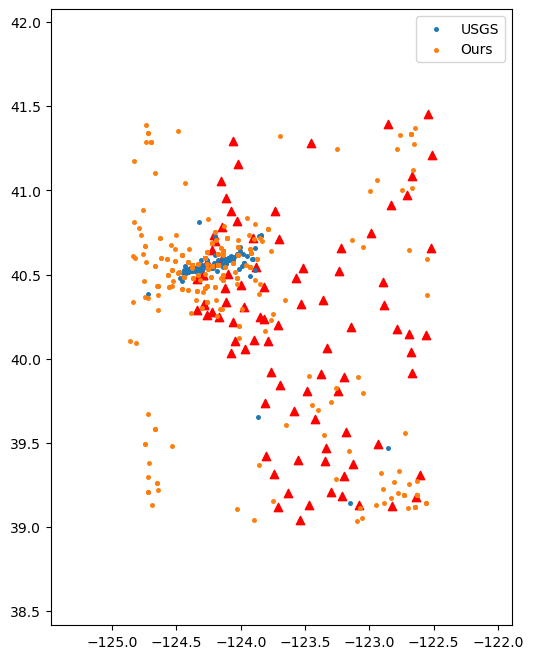

How is quality? What are issues?


In [17]:
## Plot sources
fig, ax = plt.subplots(figsize = [8,8])
plt.scatter(locs[:,1], locs[:,0], c = 'r', marker = '^')
plt.scatter(srcs_known[:,1], srcs_known[:,0], c = 'C0', s = 6.5, marker = 'o', label = 'USGS')
plt.scatter(srcs[:,1], srcs[:,0], c = 'C1', s = 6.5, marker = 'o', label = 'Ours')
ax.set_aspect(1.0/np.cos(np.pi*locs[:,0].mean()/180.0)) ## Set projection aspect ratio
d_pad = 0.5 ## Pad 0.5 degrees to plot axes
ax.set_xlim(np.array(ax.get_xlim()) + np.array([-d_pad, d_pad]))
ax.set_ylim(np.array(ax.get_ylim()) + np.array([-d_pad, d_pad]))
plt.legend()
plt.show(block = False)
print('How is quality? What are issues?')

## Now we'll run the part of the GNN that predicts *associations* for these events, and then locates them with travel time residual minimization (will take a few ~minutes to run).

In [18]:
## Run post processing detections.
print('check the thresh assoc %f'%thresh_assoc)

## Refine this

n_segment = 1
srcs_list = []
n_intervals = int(np.floor(srcs.shape[0]/n_segment))

for i in range(n_intervals):
    srcs_list.append(np.arange(n_segment) + i*n_segment)

if len(srcs_list) == 0:
    srcs_list.append(np.arange(srcs.shape[0]))
elif srcs_list[-1][-1] < (srcs.shape[0] - 1):
    srcs_list.append(np.arange(srcs_list[-1][-1] + 1, srcs.shape[0]))

## This section is memory intensive if lots of sources are detected.
## Can "loop" over segements of sources, to keep the cost for manegable.

print('Begin sources refined')
srcs_refined_l = []
trv_out_srcs_l = []
Out_p_save_l = []
Out_s_save_l = []

Save_picks = [] # save all picks..
lp_meta_l = []

for n in range(len(srcs_list)):

    Out_refined = []
    X_query_1_list = []
    X_query_1_cart_list = []

    srcs_slice = srcs[srcs_list[n]]
    trv_out_srcs_slice = trv_out_srcs[srcs_list[n]]

    for i in range(srcs_slice.shape[0]):
        # X_query = srcs[i,0:3] + X_offset
        X_query_1 = srcs_slice[i,0:3] + (np.random.rand(n_rand_query,3)*(X_offset.max(0, keepdims = True) - X_offset.min(0, keepdims = True)) + X_offset.min(0, keepdims = True))
        inside = np.where((X_query_1[:,0] > lat_range[0])*(X_query_1[:,0] < lat_range[1])*(X_query_1[:,1] > lon_range[0])*(X_query_1[:,1] < lon_range[1])*(X_query_1[:,2] > depth_range[0])*(X_query_1[:,2] < depth_range[1]))[0]
        X_query_1 = X_query_1[inside]
        X_query_1_cart = torch.Tensor(ftrns1(np.copy(X_query_1))).to(device) # 
        X_query_1_list.append(X_query_1)
        X_query_1_cart_list.append(X_query_1_cart)

        Out_refined.append(np.zeros((X_query_1.shape[0], len(tq))))

    # with torch.no_grad(): 
    
    for x_grid_ind in x_grid_ind_list_1:

        if use_updated_input == False:
        
            [Inpts, Masks], [lp_times, lp_stations, lp_phases, lp_meta] = extract_inputs_from_data_fixed_grids_with_phase_type(trv, locs, ind_use, P, P[:,4], arrivals_tree, srcs_slice[:,3], x_grids[x_grid_ind], x_grids_trv[x_grid_ind], lat_range_extend, lon_range_extend, depth_range, max_t, training_params, graph_params, pred_params, ftrns1, ftrns2)

        else:
        
            [Inpts, Masks], [lp_times, lp_stations, lp_phases, lp_meta] = extract_input_from_data(trv_pairwise, P, srcs_slice[:,3], ind_use, locs, x_grids[x_grid_ind], A_src_in_sta_l[x_grid_ind], trv_times = x_grids_trv[x_grid_ind], max_t = max_t, kernel_sig_t = pred_params[1], dt = dt_embed_discretize, device = device)
        
        # if use_subgraph == True:
        # 	for i in range(len(Inpts)):
        #                 Inpts[i] = Inpts[i].reshape(x_grids[x_grid_ind].shape[0], locs_use.shape[0], 4)[A_src_in_sta_l[x_grid_ind][1], A_src_in_sta_l[x_grid_ind][0]] # .cpu().detach().numpy()
        #                 Masks[i] = Masks[i].reshape(x_grids[x_grid_ind].shape[0], locs_use.shape[0], 4)[A_src_in_sta_l[x_grid_ind][1], A_src_in_sta_l[x_grid_ind][0]] # .cpu().detach().numpy()
        
        
        if use_phase_types == False:
            for i in range(len(Inpts)):
                Inpts[i][:,2::] = 0.0 ## Phase type informed features zeroed out
                Masks[i][:,2::] = 0.0
    
        for i in range(srcs_slice.shape[0]):

            if len(lp_times[i]) == 0:
                continue ## It will fail if len(lp_times[i0]) == 0!

            ipick, tpick = lp_stations[i].astype('int'), lp_times[i] ## are these constant across different x_grid_ind?
            
            # note, trv_out_sources, is already on cuda, may cause memory issue with too many sources
            out = mz_list[x_grid_ind].forward_fixed_source(torch.Tensor(Inpts[i]).to(device), torch.Tensor(Masks[i]).to(device), torch.Tensor(lp_times[i]).to(device), torch.Tensor(lp_stations[i]).long().to(device), torch.Tensor(lp_phases[i].reshape(-1,1)).float().to(device), torch.Tensor(ftrns1(locs_use)).to(device), x_grids_cart_torch[x_grid_ind], X_query_1_cart_list[i], tq)
            Out_refined[i] += out[1][:,:,0].cpu().detach().numpy()/n_scale_x_grid_1

    srcs_refined = []
    for i in range(srcs_slice.shape[0]):

        ip_argmax = np.argmax(Out_refined[i].max(1))
        ipt_argmax = np.argmax(Out_refined[i][ip_argmax,:])
        srcs_refined.append(np.concatenate((X_query_1_list[i][ip_argmax].reshape(1,-1), np.array([srcs_slice[i,3] + tq[ipt_argmax,0].item(), Out_refined[i].max()]).reshape(1,-1)), axis = 1)) 

    srcs_refined = np.vstack(srcs_refined)
    srcs_refined = srcs_refined[np.argsort(srcs_refined[:,3])] # note, this

    # re_apply_local_marching = True
    # if re_apply_local_marching == True: ## This way, some events that were too far apart during initial LocalMarching
    # 	## routine can now be grouped into one, since they are closer after the srcs_refined relocation step.
    # 	## Note: ideally, this clustering should be done outside of the srcs_list loop, since nearby sources
    # 	## may be artificically cut into seperate groups in srcs_list. Can end the srcs_list loop, run this
    # 	## clustering, and then run the srcs_list group over the association results.
    # 	mp = LocalMarching()
    # 	srcs_refined = mp(srcs_refined, ftrns1, tc_win = tc_win, sp_win = sp_win, scale_depth = scale_depth_clustering)
    
    ## Can do multiple grids simultaneously, for a single source? (by duplicating the source?)
    trv_out_srcs_slice = trv(torch.Tensor(locs_use).to(device), torch.Tensor(srcs_refined[:,0:3]).to(device)).detach() # .cpu().detach().numpy() # + srcs[:,3].reshape(-1,1,1)		

    srcs_refined_l.append(srcs_refined)
    trv_out_srcs_l.append(trv_out_srcs_slice)

    ## Dense, spatial view.
    d_deg = 0.1
    x1 = np.arange(lat_range[0], lat_range[1] + d_deg, d_deg)
    x2 = np.arange(lon_range[0], lon_range[1] + d_deg, d_deg)
    x3 = np.array([0.0]) # This value is overwritten in the next step
    x11, x12, x13 = np.meshgrid(x1, x2, x3)
    xx = np.concatenate((x11.reshape(-1,1), x12.reshape(-1,1), x13.reshape(-1,1)), axis = 1)
    X_save = np.copy(xx)[0,:].reshape(1,-1)
    # X_save = X_save[0].reshape(1,-1) ## X_save is not actually used
    X_save_cart = torch.Tensor(ftrns1(X_save))

    # with torch.no_grad(): 
    
    for inc, x_grid_ind in enumerate(x_grid_ind_list_1):

        if use_updated_input == False:
        
            [Inpts, Masks], [lp_times, lp_stations, lp_phases, lp_meta] = extract_inputs_from_data_fixed_grids_with_phase_type(trv, locs, ind_use, P, P[:,4], arrivals_tree, srcs_refined[:,3], x_grids[x_grid_ind], x_grids_trv[x_grid_ind], lat_range_extend, lon_range_extend, depth_range, max_t, training_params, graph_params, pred_params, ftrns1, ftrns2)

        else:

            [Inpts, Masks], [lp_times, lp_stations, lp_phases, lp_meta] = extract_input_from_data(trv_pairwise, P, srcs_refined[:,3], ind_use, locs, x_grids[x_grid_ind], A_src_in_sta_l[x_grid_ind], trv_times = x_grids_trv[x_grid_ind], max_t = max_t, kernel_sig_t = pred_params[1], dt = dt_embed_discretize, device = device)				

        # if use_subgraph == True:
        # 	for i in range(len(Inpts)):
        #                 Inpts[i] = Inpts[i].reshape(x_grids[x_grid_ind].shape[0], locs_use.shape[0], 4)[A_src_in_sta_l[x_grid_ind][1], A_src_in_sta_l[x_grid_ind][0]] # .cpu().detach().numpy()
        #                 Masks[i] = Masks[i].reshape(x_grids[x_grid_ind].shape[0], locs_use.shape[0], 4)[A_src_in_sta_l[x_grid_ind][1], A_src_in_sta_l[x_grid_ind][0]] # .cpu().detach().numpy()

        
        if use_phase_types == False:
            for i in range(len(Inpts)):
                Inpts[i][:,2::] = 0.0 ## Phase type informed features zeroed out
                Masks[i][:,2::] = 0.0
        
        if inc == 0:

            Out_p_save = [np.zeros(len(lp_times[j])) for j in range(srcs_refined.shape[0])]
            Out_s_save = [np.zeros(len(lp_times[j])) for j in range(srcs_refined.shape[0])]

        for i in range(srcs_refined.shape[0]):

            # Does this cause any issues? Could each ipick, tpick, not be constant, between grids?
            ipick, tpick = lp_stations[i].astype('int'), lp_times[i]

            if inc == 0:

                Save_picks.append(np.concatenate((tpick.reshape(-1,1), ipick.reshape(-1,1)), axis = 1))
                lp_meta_l.append(lp_meta[i])

            X_save[:,2] = srcs_refined[i,2]
            X_save_cart = torch.Tensor(ftrns1(X_save)).to(device)

            if len(lp_times[i]) == 0:
                continue ## It will fail if len(lp_times[i0]) == 0!				
            
            out = mz_list[x_grid_ind].forward_fixed(torch.Tensor(Inpts[i]).to(device), torch.Tensor(Masks[i]).to(device), torch.Tensor(lp_times[i]).to(device), torch.Tensor(lp_stations[i]).long().to(device), torch.Tensor(lp_phases[i].reshape(-1,1)).long().to(device), torch.Tensor(ftrns1(locs_use)).to(device), x_grids_cart_torch[x_grid_ind], X_save_cart, torch.Tensor(ftrns1(srcs_refined[i,0:3].reshape(1,-1))).to(device), tq, torch.zeros(1).to(device), trv_out_srcs_slice[[i],:,:])
            # Out_save[i,:,:] += out[1][:,:,0].cpu().detach().numpy()/n_scale_x_grid_1
            Out_p_save[i] += out[2][0,:,0].cpu().detach().numpy()/n_scale_x_grid_1
            Out_s_save[i] += out[3][0,:,0].cpu().detach().numpy()/n_scale_x_grid_1

    for i in range(srcs_refined.shape[0]):
        Out_p_save_l.append(Out_p_save[i])
        Out_s_save_l.append(Out_s_save[i])



srcs_refined = np.vstack(srcs_refined_l)

mp = LocalMarching(device = device)
srcs_refined_1 = mp(srcs_refined, ftrns1, tc_win = tc_win, sp_win = sp_win, scale_depth = scale_depth_clustering)

tree_refined = cKDTree(ftrns1(srcs_refined))
ip_retained = tree_refined.query(ftrns1(srcs_refined_1))[1]

Out_p_save = [Out_p_save_l[i] for i in ip_retained]
Out_s_save = [Out_s_save_l[i] for i in ip_retained]
lp_meta_l = [lp_meta_l[i] for i in ip_retained]
Save_picks = [Save_picks[i] for i in ip_retained]
srcs_refined = srcs_refined[ip_retained]

trv_out_srcs = trv(torch.Tensor(locs_use).to(device), torch.Tensor(srcs_refined[:,0:3]).to(device)).cpu().detach()

print('Begin competetive assignment')
iargsort = np.argsort(srcs_refined[:,3])
srcs_refined = srcs_refined[iargsort]
trv_out_srcs = trv_out_srcs[iargsort]
Out_p_save = [Out_p_save[i] for i in iargsort]
Out_s_save = [Out_s_save[i] for i in iargsort]
Save_picks = [Save_picks[i] for i in iargsort]
lp_meta = [lp_meta_l[i] for i in iargsort]

if (use_expanded_competitive_assignment == False) or (len(srcs_refined) <= 1):

    Assigned_picks = []
    Picks_P = []
    Picks_S = []
    Picks_P_perm = []
    Picks_S_perm = []
    # Out_save = []

    ## Implement CA, so that is runs over disjoint sets of "nearby" sources.
    ## Rather than individually, for each source.
    for i in range(srcs_refined.shape[0]):

        ## Now do assignments, on the stacked association predictions (over grids)

        ipick, tpick = Save_picks[i][:,1].astype('int'), Save_picks[i][:,0]

        print(i)

        ## Need to replace this with competitive assignment over "connected"
        ## Sources. This will reduce duplicate events.
        wp = np.zeros((1,len(tpick))); wp[0,:] = Out_p_save[i]
        ws = np.zeros((1,len(tpick))); ws[0,:] = Out_s_save[i]
        wp[wp <= thresh_assoc] = 0.0
        ws[ws <= thresh_assoc] = 0.0
        assignments, srcs_active = competitive_assignment([wp, ws], ipick, 1.5, force_n_sources = 1) ## force 1 source?
        

        # Note, calling tree_picks
        ip_picks = tree_picks.query(lp_meta[i][:,0:2]) # meta uses absolute indices
        assert(abs(ip_picks[0]).max() == 0.0)
        ip_picks = ip_picks[1]

        # p_pred, s_pred = np.zeros(len(tpick)), np.zeros(len(tpick))
        assert(len(srcs_active) == 1)
        ## Assumes 1 source

        ind_p = ipick[assignments[0][0]]
        ind_s = ipick[assignments[0][1]]
        arv_p = tpick[assignments[0][0]]
        arv_s = tpick[assignments[0][1]]

        p_assign = np.concatenate((P[ip_picks[assignments[0][0]],:], i*np.ones(len(assignments[0][0])).reshape(-1,1)), axis = 1) ## Note: could concatenate ip_picks, if desired here, so all picks in Picks_P lists know the index of the absolute pick index.
        s_assign = np.concatenate((P[ip_picks[assignments[0][1]],:], i*np.ones(len(assignments[0][1])).reshape(-1,1)), axis = 1)
        p_assign_perm = np.copy(p_assign)
        s_assign_perm = np.copy(s_assign)
        p_assign_perm[:,1] = perm_vec[p_assign_perm[:,1].astype('int')]
        s_assign_perm[:,1] = perm_vec[s_assign_perm[:,1].astype('int')]
        Picks_P.append(p_assign)
        Picks_S.append(s_assign)
        Picks_P_perm.append(p_assign_perm)
        Picks_S_perm.append(s_assign_perm)

        print('add relocation!')

        ## Implemente CA, to deal with mixing events (nearby in time, with shared arrival association assignments)

elif use_expanded_competitive_assignment == True:

    Assigned_picks = []
    Picks_P = []
    Picks_S = []
    Picks_P_perm = []
    Picks_S_perm = []
    # Out_save = []

    ## Implement CA, so that is runs over disjoint sets of "nearby" sources.
    ## Rather than individually, for each source.

    # ## Find overlapping events (events with shared pick assignments)
    all_picks = np.vstack(lp_meta) # [:,0:2] # np.vstack([Save_picks[i] for i in range(len(Save_picks))])
    # unique_picks = np.unique(all_picks[:,0:2], axis = 0)
    unique_picks = np.unique(all_picks, axis = 0)

    # ip_sort_unique = np.lexsort((unique_picks[:,0], unique_picks[:,1])) # sort by station
    ip_sort_unique = np.lexsort((unique_picks[:,1], unique_picks[:,0])) # sort by time
    unique_picks = unique_picks[ip_sort_unique]
    len_unique_picks = len(unique_picks)

    # tree_picks_select = cKDTree(all_picks[:,0:2])
    tree_picks_unique_select = cKDTree(unique_picks[:,0:2])
    # lp_tree_picks_select  = tree_picks_select.query_ball_point(unique_picks, r = 0)

    matched_src_arrival_indices = []
    matched_src_arrival_indices_p = []
    matched_src_arrival_indices_s = []

    min_picks = 4

    for i in range(len(lp_meta)):

        if len(lp_meta[i]) == 0:
            continue

        matched_arv_indices_val = tree_picks_unique_select.query(lp_meta[i][:,0:2])
        assert(matched_arv_indices_val[0].max() == 0)
        matched_arv_indices = matched_arv_indices_val[1]

        ifind_p = np.where(Out_p_save[i] > thresh_assoc)[0]
        ifind_s = np.where(Out_s_save[i] > thresh_assoc)[0]

        # Check for minimum number of picks, otherwise, skip source
        if (len(ifind_p) + len(ifind_s)) >= min_picks:

            ifind = np.unique(np.concatenate((ifind_p, ifind_s), axis = 0)) # Create combined set of indices

            ## concatenate both p and s likelihoods and edges for all of ifind, so that the dense matrices extracted for each
            ## disconnected component are the same size.

            ## First row is arrival indices, second row are src indices
            # if len(ifind_p) > 0:
            # matched_src_arrival_indices_p.append(np.concatenate((matched_arv_indices[ifind_p].reshape(1,-1), i*np.ones(len(ifind_p)).reshape(1,-1), Out_p_save[i][ifind_p].reshape(1,-1)), axis = 0))
            matched_src_arrival_indices_p.append(np.concatenate((matched_arv_indices[ifind].reshape(1,-1), i*np.ones(len(ifind)).reshape(1,-1), Out_p_save[i][ifind].reshape(1,-1)), axis = 0))

            # if len(ifind_s) > 0:
            # matched_src_arrival_indices_s.append(np.concatenate((matched_arv_indices[ifind_s].reshape(1,-1), i*np.ones(len(ifind_s)).reshape(1,-1), Out_s_save[i][ifind_s].reshape(1,-1)), axis = 0))
            matched_src_arrival_indices_s.append(np.concatenate((matched_arv_indices[ifind].reshape(1,-1), i*np.ones(len(ifind)).reshape(1,-1), Out_s_save[i][ifind].reshape(1,-1)), axis = 0))

            matched_src_arrival_indices.append(np.concatenate((matched_arv_indices[ifind].reshape(1,-1), i*np.ones(len(ifind)).reshape(1,-1), np.concatenate((Out_p_save[i][ifind].reshape(1,-1), Out_s_save[i][ifind].reshape(1,-1)), axis = 0).max(0, keepdims = True)), axis = 0))

    ## From this, we may not have memory issues with competitive assignment. If so,
    ## can still reduce the size of disjoint groups.

    matched_src_arrival_indices = np.hstack(matched_src_arrival_indices)
    matched_src_arrival_indices_p = np.hstack(matched_src_arrival_indices_p)
    matched_src_arrival_indices_s = np.hstack(matched_src_arrival_indices_s)

    ## Convert to linear graph, find disconected components, apply CA

    w_edges = np.concatenate((matched_src_arrival_indices[0,:][None,:], matched_src_arrival_indices[1,:][None,:] + len_unique_picks, matched_src_arrival_indices[2,:].reshape(1,-1)), axis = 0)
    wp_edges = np.concatenate((matched_src_arrival_indices_p[0,:][None,:], matched_src_arrival_indices_p[1,:][None,:] + len_unique_picks, matched_src_arrival_indices_p[2,:].reshape(1,-1)), axis = 0)
    ws_edges = np.concatenate((matched_src_arrival_indices_s[0,:][None,:], matched_src_arrival_indices_s[1,:][None,:] + len_unique_picks, matched_src_arrival_indices_s[2,:].reshape(1,-1)), axis = 0)
    assert(np.abs(wp_edges[0:2,:] - ws_edges[0:2,:]).max() == 0)

    ## w_edges: first row are unique arrival indices
    ## w_edges: second row are unique src indices (with index 0 being the len(unique_picks))

    ## Need to combined wp and ws graphs
    G_nx = nx.Graph()
    G_nx.add_weighted_edges_from(w_edges.T)
    G_nx.add_weighted_edges_from(w_edges[np.array([1,0,2]),:].T)

    Gp_nx = nx.Graph()
    Gp_nx.add_weighted_edges_from(wp_edges.T)
    Gp_nx.add_weighted_edges_from(wp_edges[np.array([1,0,2]),:].T)

    Gs_nx = nx.Graph()
    Gs_nx.add_weighted_edges_from(ws_edges.T)
    Gs_nx.add_weighted_edges_from(ws_edges[np.array([1,0,2]),:].T)

    discon_components = list(nx.connected_components(G_nx))
    discon_components = [np.sort(np.array(list(discon_components[i])).astype('int')) for i in range(len(discon_components))]

    finish_splits = False
    max_sources = 15 ## per competitive assignment run
    max_splits = 30
    num_splits = 0
    while finish_splits == False:

        remove_edges_from = []

        discon_components = list(nx.connected_components(G_nx))
        discon_components = [np.sort(np.array(list(discon_components[i])).astype('int')) for i in range(len(discon_components))]

        ## Should the below line really use a where function? It seems like this is a "where" on a scalar velue everytime, so it is guarenteed to evaluate as 1
        len_discon = np.array([len(np.where(discon_components[j] > (len_unique_picks - 1))[0]) for j in range(len(discon_components))])
        print('Number discon components: %d \n'%(len(len_discon)))
        print('Number large discon components: %d \n'%(len(np.where(len_discon > max_sources)[0])))
        print('Largest discon component: %d \n'%(max(len_discon)))

        if (len(np.where(len_discon > max_sources)[0]) == 0) or (num_splits > max_splits):
            finish_splits = True
            continue

        print('Beginning split step %d'%num_splits)

        for i in range(len(discon_components)):

            subset_edges = G_nx.subgraph(discon_components[i])
            adj_matrix = nx.adjacency_matrix(subset_edges, nodelist = discon_components[i]).toarray() # nodelist = np.arange(len(discon_components[i]))).toarray()

            subset_edges = Gp_nx.subgraph(discon_components[i])
            adj_matrix_p = nx.adjacency_matrix(subset_edges, nodelist = discon_components[i]).toarray() # nodelist = np.arange(len(discon_components[i]))).toarray()

            subset_edges = Gs_nx.subgraph(discon_components[i])
            adj_matrix_s = nx.adjacency_matrix(subset_edges, nodelist = discon_components[i]).toarray() # nodelist = np.arange(len(discon_components[i]))).toarray()

            # ifind_matched_inds = tree_srcs.query(w_edges[0:2,discon_components[i]].T)[1]

            ## Apply CA to the subset of sources/picks in a disconnected component
            ifind_src_inds = np.where(discon_components[i] > (len_unique_picks - 1))[0]
            ifind_arv_inds = np.delete(np.arange(len(discon_components[i])), ifind_src_inds, axis = 0)

            arv_ind_slice = np.sort(discon_components[i][ifind_arv_inds])
            arv_src_slice = np.sort(discon_components[i][ifind_src_inds]) - len_unique_picks
            len_arv_slice = len(arv_ind_slice)

            tpick = unique_picks[arv_ind_slice,0]
            ipick = unique_picks[arv_ind_slice,1].astype('int')

            if len(ifind_src_inds) <= max_sources:

                pass

            elif len(ifind_src_inds) > max_sources:

                ## Create a source-source index graph, based on how much they "share" arrivals. Then find min-cut on this graph,
                ## to seperate sources. Modify the discon_components so the sources are split.

                w_slice = adj_matrix[len_arv_slice::,0:len_arv_slice] # np.zeros((len(arv_src_slice), len(arv_ind_slice)))
                wp_slice = adj_matrix_p[len_arv_slice::,0:len_arv_slice] # np.zeros((len(arv_src_slice), len(arv_ind_slice)))
                ws_slice = adj_matrix_s[len_arv_slice::,0:len_arv_slice] # np.zeros((len(arv_src_slice), len(arv_ind_slice)))

                isource, iarv = np.where(w_slice > thresh_assoc)
                tree_src_ind = cKDTree(isource.reshape(-1,1)) ## all sources should appear here
                # lp_src_ind = tree_src_ind.query_ball_point(np.sort(np.unique(isource)).reshape(-1,1), r = 0)
                lp_src_ind = tree_src_ind.query_ball_point(np.arange(len(ifind_src_inds)).reshape(-1,1), r = 0)

                assert(len(np.sort(np.unique(isource))) == len(ifind_src_inds))

                ## Note: could concievably use MCL on these graphs, just like in original association application.
                ## May want to use MCL even on the original source-time graphs as well.
                
                w_src_adj = np.zeros((len(ifind_src_inds), len(ifind_src_inds)))

                for j in range(len(ifind_src_inds)):
                    for k in range(len(ifind_src_inds)):
                        if j == k:
                            continue
                        if (len(lp_src_ind[j]) > 0)*(len(lp_src_ind[k]) > 0):
                            w_src_adj[j,k] = len(list(set(iarv[lp_src_ind[j]]).intersection(iarv[lp_src_ind[k]])))

                ## Simply split sources into groups of two (need to make sure this rarely cuts off indidual sources)
                clusters = SpectralClustering(n_clusters = 2, affinity = 'precomputed').fit_predict(w_src_adj)

                i1, i2 = np.where(clusters == 0)[0], np.where(clusters == 1)[0]

                ## Optimize all (union) of picks between split sources, so can determine which edges (between arrivals and sources) to delete
                ## This should `trim' the source-arrival graphs and increase amount of disconnected components.

                # min_time1, min_time2 = srcs_refined[ifind_src_inds[i1],3].min(), srcs_refined[ifind_src_inds[i2],3].min()
                min_time1, min_time2 = srcs_refined[arv_src_slice[i1],3].min(), srcs_refined[arv_src_slice[i2],3].min()

                if min_time1 <= min_time2:
                    # cutset = nx.minimum_edge_cut(g_src, s = max(i1), t = min(i2))
                    pass
                else:
                    i3 = np.copy(i1)
                    i1 = np.copy(i2)
                    i2 = np.copy(i3)

                ## Instead of cut-set, find all sources that "link" across the two groups. Use these as reference sources.
                ## In bad cases, could this set also be too big?
                cutset_left = []
                cutset_right = []
                for j in range(len(i1)):
                    cutset_right.append(i2[np.where(w_src_adj[i1[j],i2] > 0)[0]])
                for j in range(len(i2)):
                    cutset_left.append(i1[np.where(w_src_adj[i2[j],i1] > 0)[0]])

                cutset_left = np.unique(np.hstack(cutset_left))	
                cutset_right = np.unique(np.hstack(cutset_right))	
                cutset = np.unique(np.concatenate((cutset_left, cutset_right), axis = 0))

                ## Extract the arrival-source weights from w_edges for these nodes
                ## Then "take max value" of these picks across these sources
                ## Then use CA to maximize assignment of picks to either "distinct"
                ## cluster. Then remove those arrival attachements from the full graph
                ## for the cluster the picks arn't assigned too. Then, do this for all
                ## disconnected graphs, update the disconnected components, and iterate
                ## until all graphs are less than or equal to maximum size.

                # cutset = np.array(list(cutset)).astype('int')
                unique_src_inds = np.sort(np.unique(cutset.reshape(-1,1))).astype('int')
                arv_indices_sliced = np.where(w_slice[unique_src_inds,:].max(0) > thresh_assoc)[0]

                arv_weights_p_cluster_1 = wp_slice[np.unique(cutset_left).astype('int').reshape(-1,1), arv_indices_sliced.reshape(1,-1)].max(0).reshape(1,-1)
                arv_weights_s_cluster_1 = ws_slice[np.unique(cutset_left).astype('int').reshape(-1,1), arv_indices_sliced.reshape(1,-1)].max(0).reshape(1,-1)

                arv_weights_p_cluster_2 = wp_slice[np.unique(cutset_right).astype('int').reshape(-1,1), arv_indices_sliced.reshape(1,-1)].max(0).reshape(1,-1)
                arv_weights_s_cluster_2 = ws_slice[np.unique(cutset_right).astype('int').reshape(-1,1), arv_indices_sliced.reshape(1,-1)].max(0).reshape(1,-1)

                arv_weights_p = np.concatenate((arv_weights_p_cluster_1, arv_weights_p_cluster_2), axis = 0)
                arv_weights_s = np.concatenate((arv_weights_s_cluster_1, arv_weights_s_cluster_2), axis = 0)

                ## Now: use competitive assignment to optimize pick assignments to either cluster (use a cost on sources, or no?)
                # assignment_picks, srcs_active_picks = competitive_assignment_split([arv_weights_p, arv_weights_s], ipick[arv_indices_sliced], 1.0) ## force 1 source?
                assignment_picks, srcs_active_picks = competitive_assignment_split([arv_weights_p, arv_weights_s], ipick[arv_indices_sliced], 0.0) ## force 1 source?
                node_all_arrivals = arv_ind_slice[arv_indices_sliced]

                if len(assignment_picks) > 0:
                    assign_picks_1 = np.unique(np.hstack(assignment_picks[0]))
                else:
                    assign_picks_1 = np.array([])

                ## Cut these arrivals from sources in group 1
                node_src_1 = arv_src_slice[cutset_left] + len_unique_picks
                node_arrival_1_del = np.delete(node_all_arrivals, assign_picks_1, axis = 0)
                node_arrival_1_repeat = np.repeat(node_arrival_1_del, len(node_src_1), axis = 0)
                node_src_1_repeat = np.tile(node_src_1, len(node_arrival_1_del))
                remove_edges_from.append(np.concatenate((node_arrival_1_repeat.reshape(1,-1), node_src_1_repeat.reshape(1,-1)), axis = 0))

                if len(assignment_picks) > 1:
                    assign_picks_2 = np.unique(np.hstack(assignment_picks[1]))
                    # node_arrival_2 = arv_ind_slice[arv_indices_sliced[assign_picks_2]]
                else:
                    # node_arrival_2 = np.array([])
                    assign_picks_2 = np.array([])

                node_src_2 = arv_src_slice[cutset_right] + len_unique_picks
                node_arrival_2_del = np.delete(node_all_arrivals, assign_picks_2, axis = 0)
                node_arrival_2_repeat = np.repeat(node_arrival_2_del, len(node_src_2), axis = 0)
                node_src_2_repeat = np.tile(node_src_2, len(node_arrival_2_del))
                remove_edges_from.append(np.concatenate((node_arrival_2_repeat.reshape(1,-1), node_src_2_repeat.reshape(1,-1)), axis = 0))

                print('%d %d %d'%(len(arv_ind_slice), sum(clusters == 0), sum(clusters == 1)))

        if len(remove_edges_from) > 0:
            remove_edges_from = np.hstack(remove_edges_from)
            remove_edges_from = np.concatenate((remove_edges_from, np.flip(remove_edges_from, axis = 0)), axis = 1)

            G_nx.remove_edges_from(remove_edges_from.T)
            Gp_nx.remove_edges_from(remove_edges_from.T)
            Gs_nx.remove_edges_from(remove_edges_from.T)

        num_splits = num_splits + 1

    srcs_retained = []
    cnt_src = 0

    for i in range(len(discon_components)):

        ## Need to check that each subgraph and sets of edges are for same combinations of source-arrivals,
        ## for all three graphs.

        subset_edges = G_nx.subgraph(discon_components[i])
        adj_matrix = nx.adjacency_matrix(subset_edges, nodelist = discon_components[i]).toarray() # nodelist = np.arange(len(discon_components[i]))).toarray()

        subset_edges = Gp_nx.subgraph(discon_components[i])
        adj_matrix_p = nx.adjacency_matrix(subset_edges, nodelist = discon_components[i]).toarray() # nodelist = np.arange(len(discon_components[i]))).toarray()

        subset_edges = Gs_nx.subgraph(discon_components[i])
        adj_matrix_s = nx.adjacency_matrix(subset_edges, nodelist = discon_components[i]).toarray() # nodelist = np.arange(len(discon_components[i]))).toarray()

        ## Apply CA to the subset of sources/picks in a disconnected component
        ifind_src_inds = np.where(discon_components[i] > (len_unique_picks - 1))[0]
        ifind_arv_inds = np.delete(np.arange(len(discon_components[i])), ifind_src_inds, axis = 0)

        arv_ind_slice = np.sort(discon_components[i][ifind_arv_inds])
        arv_src_slice = np.sort(discon_components[i][ifind_src_inds]) - len_unique_picks
        len_arv_slice = len(arv_ind_slice)

        wp_slice = adj_matrix_p[len_arv_slice::,0:len_arv_slice] # np.zeros((len(arv_src_slice), len(arv_ind_slice)))
        ws_slice = adj_matrix_s[len_arv_slice::,0:len_arv_slice] # np.zeros((len(arv_src_slice), len(arv_ind_slice)))
        
        tpick = unique_picks[arv_ind_slice,0]
        ipick = unique_picks[arv_ind_slice,1].astype('int')

        ## Now do assignments, on the stacked association predictions (over grids)

        if (len(ipick) == 0) or (len(arv_src_slice) == 0):
            continue

        # thresh_assoc = 0.125
        wp_slice[wp_slice <= thresh_assoc] = 0.0
        ws_slice[ws_slice <= thresh_assoc] = 0.0
        # assignments, srcs_active = competitive_assignment([wp_slice, ws_slice], ipick, 1.5, force_n_sources = 1) ## force 1 source?
        assignments, srcs_active = competitive_assignment([wp_slice, ws_slice], ipick, cost_value) ## force 1 source?

        if len(srcs_active) > 0:

            for j in range(len(srcs_active)):


                srcs_retained.append(srcs_refined[arv_src_slice[srcs_active[j]]].reshape(1,-1))

                wp_val = wp_slice[srcs_active[j], assignments[j][0]]
                ws_val = ws_slice[srcs_active[j], assignments[j][1]]
                
                p_assign = np.concatenate((unique_picks[arv_ind_slice[assignments[j][0]],:], cnt_src*np.ones(len(assignments[j][0])).reshape(-1,1), wp_val.reshape(-1,1)), axis = 1) ## Note: could concatenate ip_picks, if desired here, so all picks in Picks_P lists know the index of the absolute pick index.
                s_assign = np.concatenate((unique_picks[arv_ind_slice[assignments[j][1]],:], cnt_src*np.ones(len(assignments[j][1])).reshape(-1,1), ws_val.reshape(-1,1)), axis = 1)
                p_assign_perm = np.copy(p_assign)
                s_assign_perm = np.copy(s_assign)
                p_assign_perm[:,1] = perm_vec[p_assign_perm[:,1].astype('int')]
                s_assign_perm[:,1] = perm_vec[s_assign_perm[:,1].astype('int')]
                Picks_P.append(p_assign)
                Picks_S.append(s_assign)
                Picks_P_perm.append(p_assign_perm)
                Picks_S_perm.append(s_assign_perm)

                cnt_src += 1

        print('%d : %d of %d'%(i, len(srcs_active), len(arv_src_slice)))

        ## Find unique set of arrival indices, write to subset of matrix weights
        ## for wp and ws.

        ## Then solve CA. Need to scale weights so that: (i). Primarily, the cost is related to the number
        ## of picks per event, and (ii). It still identifies "good" fit and "bad" fit source-arrival pairs,
        ## based on the source-arrival weights.

    if len(srcs_retained) == 0:
        print('No events left after competitive assignment (e.g., cost is too high w.r.t. amount of available picks)')
        # continue
    
    srcs_refined = np.vstack(srcs_retained)


## Locate events using travel times and associated picks
srcs_trv, srcs_sigma = [], []
del_arv_p, del_arv_s = [], []
torch.set_grad_enabled(True)
for i in range(srcs_refined.shape[0]):

    arv_p, ind_p, arv_s, ind_s = Picks_P_perm[i][:,0], Picks_P_perm[i][:,1].astype('int'), Picks_S_perm[i][:,0], Picks_S_perm[i][:,1].astype('int')

    ind_unique_arrivals = np.sort(np.unique(np.concatenate((ind_p, ind_s), axis = 0)).astype('int'))

    if len(ind_unique_arrivals) == 0:
        srcs_trv.append(np.nan*np.ones((1, 4)))
        srcs_sigma.append(np.nan)
        del_arv_p.append(0)
        del_arv_s.append(0)
        continue			
    
    perm_vec_arrivals = -1*np.ones(locs_use.shape[0]).astype('int')
    perm_vec_arrivals[ind_unique_arrivals] = np.arange(len(ind_unique_arrivals))
    locs_use_slice = locs_use[ind_unique_arrivals]
    ind_p_perm_slice = perm_vec_arrivals[ind_p]
    ind_s_perm_slice = perm_vec_arrivals[ind_s]
    if len(ind_p_perm_slice) > 0:
        assert(ind_p_perm_slice.min() > -1)
    if len(ind_s_perm_slice) > 0:
        assert(ind_s_perm_slice.min() > -1)

    if use_differential_evolution_location == True:
        xmle, logprob = differential_evolution_location(trv, locs_use_slice, arv_p, ind_p_perm_slice, arv_s, ind_s_perm_slice, lat_range_extend, lon_range_extend, depth_range, surface_profile = surface_profile, device = device)
    else:
        xmle, logprob, Swarm = MLE_particle_swarm_location_one_mean_stable_depth_with_hull(trv, locs_use_slice, arv_p, ind_p_perm_slice, arv_s, ind_s_perm_slice, lat_range_extend, lon_range_extend, depth_range, dx_depth, hull, ftrns1, ftrns2)
    
    if np.isnan(xmle).sum() > 0:
        srcs_trv.append(np.nan*np.ones((1, 4)))
        srcs_sigma.append(np.nan)
        del_arv_p.append(0)
        del_arv_s.append(0)
        continue

    pred_out = trv(torch.Tensor(locs_use_slice).to(device), torch.Tensor(xmle).to(device)).cpu().detach().numpy() + srcs_refined[i,3]

    res_p = pred_out[0,ind_p_perm_slice,0] - arv_p
    res_s = pred_out[0,ind_s_perm_slice,1] - arv_s

    mean_shift = 0.0
    cnt_phases = 0
    if len(res_p) > 0:
        mean_shift += np.median(res_p)*(len(res_p)/(len(res_p) + len(res_s)))
        cnt_phases += 1

    if len(res_s) > 0:
        mean_shift += np.median(res_s)*(len(res_s)/(len(res_p) + len(res_s)))
        cnt_phases += 1

    ## This moved later, after the quality check
    # srcs_trv.append(np.concatenate((xmle, np.array([srcs_refined[i,3] - mean_shift]).reshape(1,-1)), axis = 1))

    ## Estimate uncertainties
    origin = srcs_refined[i,3] - mean_shift
    pred_out = trv(torch.Tensor(locs_use_slice).to(device), torch.Tensor(xmle[0,0:3].reshape(1,-1)).to(device)).cpu().detach().numpy() + origin # srcs_trv[-1][0,3]
    res_p = pred_out[0,ind_p_perm_slice,0] - arv_p
    res_s = pred_out[0,ind_s_perm_slice,1] - arv_s
    
    # use_quality_check = process_config['use_quality_check'] ## If True, check all associated picks and set a maximum allowed relative error after obtaining initial location
    # max_relative_error = process_config['max_relative_error'] ## 0.15 corresponds to 15% maximum relative error allowed
    # min_time_buffer = process_config['min_time_buffer'] ## Uses this time (seconds) as a minimum residual time, beneath which, the relative error criterion is ignored (i.e., an associated pick is removed if both the relative error > max_relative_error and the residual > min_time_buffer)
    if use_quality_check == True:
        tval_p = pred_out[0,ind_p_perm_slice,0] - origin
        tval_s = pred_out[0,ind_s_perm_slice,1] - origin
        tval_p[tval_p <= 0] = 0.01
        tval_s[tval_s <= 0] = 0.01
        rel_error_p = np.abs(res_p/tval_p)
        rel_error_s = np.abs(res_s/tval_s)
        # idel_p = np.where((rel_error_p > max_relative_error)*((pred_out[0,ind_p_perm_slice,0] - origin) > min_time_buffer))[0]
        # idel_s = np.where((rel_error_s > max_relative_error)*((pred_out[0,ind_s_perm_slice,1] - origin) > min_time_buffer))[0]
        idel_p = np.where((rel_error_p > max_relative_error)*(np.abs(res_p) > min_time_buffer))[0]
        idel_s = np.where((rel_error_s > max_relative_error)*(np.abs(res_s) > min_time_buffer))[0]
        del_arv_p.append(len(idel_p))
        del_arv_s.append(len(idel_s))
                  
        if len(idel_p) > 0:
            arv_p = np.delete(arv_p, idel_p, axis = 0)
            ind_p = np.delete(ind_p, idel_p, axis = 0)
            Picks_P[i] = np.delete(Picks_P[i], idel_p, axis = 0)
            Picks_P_perm[i] = np.delete(Picks_P_perm[i], idel_p, axis = 0)

        if len(idel_s) > 0:
            arv_s = np.delete(arv_s, idel_s, axis = 0)
            ind_s = np.delete(ind_s, idel_s, axis = 0)
            Picks_S[i] = np.delete(Picks_S[i], idel_s, axis = 0)
            Picks_S_perm[i] = np.delete(Picks_S_perm[i], idel_s, axis = 0)
        
        ind_unique_arrivals = np.sort(np.unique(np.concatenate((ind_p, ind_s), axis = 0)).astype('int'))

        if len(ind_unique_arrivals) == 0:
            srcs_trv.append(np.nan*np.ones((1, 4)))
            srcs_sigma.append(np.nan)
            continue			
        
        perm_vec_arrivals = -1*np.ones(locs_use.shape[0]).astype('int')
        perm_vec_arrivals[ind_unique_arrivals] = np.arange(len(ind_unique_arrivals))
        locs_use_slice = locs_use[ind_unique_arrivals]
        ind_p_perm_slice = perm_vec_arrivals[ind_p]
        ind_s_perm_slice = perm_vec_arrivals[ind_s]
        
        if len(ind_p_perm_slice) > 0:
            assert(ind_p_perm_slice.min() > -1)
        if len(ind_s_perm_slice) > 0:
            assert(ind_s_perm_slice.min() > -1)
            
        # if len(ind_unique_arrivals) == 0:
        # 	srcs_trv.append(np.nan*np.ones((1, 4)))
        # 	continue				
                            
        if ((len(idel_p) > 0) + (len(idel_s) > 0)) > 0: ## If arrivals have been removed, re-locate

            if (min_required_picks is not False)*(min_required_sta is not False):
                
                if ((len(ind_unique_arrivals) == 0) + ((len(arv_p) + len(arv_s)) < min_required_picks) + (len(np.unique(np.concatenate((ind_p, ind_s), axis = 0))) < min_required_sta)) > 0:
                    srcs_trv.append(np.nan*np.ones((1, 4)))
                    srcs_sigma.append(np.nan)
                    continue

            else:

                if len(ind_unique_arrivals) == 0:
                    srcs_trv.append(np.nan*np.ones((1, 4)))
                    srcs_sigma.append(np.nan)
                    continue
            
            if use_differential_evolution_location == True:
                xmle, logprob = differential_evolution_location(trv, locs_use_slice, arv_p, ind_p_perm_slice, arv_s, ind_s_perm_slice, lat_range_extend, lon_range_extend, depth_range, surface_profile = surface_profile, device = device)
            else:
                xmle, logprob, Swarm = MLE_particle_swarm_location_one_mean_stable_depth_with_hull(trv, locs_use_slice, arv_p, ind_p_perm_slice, arv_s, ind_s_perm_slice, lat_range_extend, lon_range_extend, depth_range, dx_depth, hull, ftrns1, ftrns2)
            
        if np.isnan(xmle).sum() > 0:
            srcs_trv.append(np.nan*np.ones((1, 4)))
            srcs_sigma.append(np.nan)
            continue
            
        pred_out = trv(torch.Tensor(locs_use_slice).to(device), torch.Tensor(xmle[0,0:3].reshape(1,-1)).to(device)).cpu().detach().numpy() + srcs_refined[i,3] # srcs_trv[-1][0,3]
        res_p = pred_out[0,ind_p_perm_slice,0] - arv_p
        res_s = pred_out[0,ind_s_perm_slice,1] - arv_s
        
        mean_shift = 0.0
        cnt_phases = 0
        if len(res_p) > 0:
            mean_shift += np.median(res_p)*(len(res_p)/(len(res_p) + len(res_s)))
            cnt_phases += 1

        if len(res_s) > 0:
            mean_shift += np.median(res_s)*(len(res_s)/(len(res_p) + len(res_s)))
            cnt_phases += 1		
    else:
        del_arv_p.append(0)
        del_arv_s.append(0)

    origin = srcs_refined[i,3] - mean_shift
    pred_out = trv(torch.Tensor(locs_use_slice).to(device), torch.Tensor(xmle[0,0:3].reshape(1,-1)).to(device)).cpu().detach().numpy() + origin # srcs_trv[-1][0,3]
    res_p = pred_out[0,ind_p_perm_slice,0] - arv_p
    res_s = pred_out[0,ind_s_perm_slice,1] - arv_s
    
    scale_val1 = 100.0*np.linalg.norm(ftrns1(xmle[0,0:3].reshape(1,-1)) - ftrns1(xmle[0,0:3].reshape(1,-1) + np.array([0.01, 0, 0]).reshape(1,-1)), axis = 1)[0]
    scale_val2 = 100.0*np.linalg.norm(ftrns1(xmle[0,0:3].reshape(1,-1)) - ftrns1(xmle[0,0:3].reshape(1,-1) + np.array([0.0, 0.01, 0]).reshape(1,-1)), axis = 1)[0]
    scale_val = 0.5*(scale_val1 + scale_val2)

    scale_partials = (1/60.0)*np.array([1.0, 1.0, scale_val]).reshape(1,-1)
    src_input_p = Variable(torch.Tensor(xmle[0,0:3].reshape(1,-1)).repeat(len(ind_p_perm_slice),1).to(device), requires_grad = True)
    src_input_s = Variable(torch.Tensor(xmle[0,0:3].reshape(1,-1)).repeat(len(ind_s_perm_slice),1).to(device), requires_grad = True)
    trv_out_p = trv_pairwise1(torch.Tensor(locs_use_slice[ind_p_perm_slice]).to(device), src_input_p, method = 'direct')[:,0]
    trv_out_s = trv_pairwise1(torch.Tensor(locs_use_slice[ind_s_perm_slice]).to(device), src_input_s, method = 'direct')[:,1]
    # trv_out = trv_out[np.arange(len(trv_out)), arrivals[n_inds_picks[i],4].astype('int')] # .cpu().detach().numpy() ## Select phase type
    d_p = scale_partials*torch.autograd.grad(inputs = src_input_p, outputs = trv_out_p, grad_outputs = torch.ones(len(trv_out_p)).to(device), retain_graph = True, create_graph = True, allow_unused = True)[0].cpu().detach().numpy()
    d_s = scale_partials*torch.autograd.grad(inputs = src_input_s, outputs = trv_out_s, grad_outputs = torch.ones(len(trv_out_s)).to(device), retain_graph = True, create_graph = True, allow_unused = True)[0].cpu().detach().numpy()
    
    d_grad = np.concatenate((d_p, d_s), axis = 0)
    sig_d = 0.15 ## Assumed pick uncertainty (seconds)
    chi_pdf = chi2(df = 3).pdf(0.99)
    
    var = (d_grad/scale_partials)
    var = np.linalg.pinv(var.T@var)*(sig_d**2)
    var = var*chi_pdf
    #Variances.append(np.expand_dims(var, axis = 0))
    var_cart = (d_grad/scale_partials)/np.array([scale_val1, scale_val2, 1.0]).reshape(1,-1)
    var_cart = np.linalg.pinv(var_cart.T@var_cart)*(sig_d**2)
    var_cart = var_cart*chi_pdf
    sigma_cart = np.linalg.norm(np.diag(var_cart)**(0.5))

    ## Append the final location and origin time
    srcs_trv.append(np.concatenate((xmle, np.array([origin]).reshape(1,-1)), axis = 1))
    srcs_sigma.append(sigma_cart)


srcs_trv = np.vstack(srcs_trv)
srcs_sigma = np.hstack(srcs_sigma)
del_arv_p = np.hstack(del_arv_p)
del_arv_s = np.hstack(del_arv_s)
assert(len(srcs_trv) == len(srcs_sigma))
assert(len(srcs_trv) == len(del_arv_p))
assert(len(srcs_trv) == len(del_arv_s))
assert(len(srcs_trv) == len(Picks_P))
assert(len(srcs_trv) == len(Picks_S))
assert(len(srcs_trv) == len(srcs_refined))
###### Only keep events with minimum number of picks and observing stations #########

# Count number of P and S picks
cnt_p, cnt_s = np.zeros(srcs_refined.shape[0]), np.zeros(srcs_refined.shape[0])
for i in range(srcs_refined.shape[0]):
    cnt_p[i] = Picks_P[i].shape[0]
    cnt_s[i] = Picks_S[i].shape[0]

# min_required_picks = 6
# min_required_sta = 6

if (min_required_picks is not False)*(min_required_sta is not False):

    ikeep_picks = np.where((cnt_p + cnt_s) >= min_required_picks)[0]
    ikeep_sta = np.where(np.array([len(np.unique(np.concatenate((Picks_P[j][:,1], Picks_S[j][:,1]), axis = 0))) for j in range(len(srcs_refined))]) >= min_required_sta)[0]
    ikeep = np.sort(np.array(list(set(ikeep_picks).intersection(ikeep_sta))))

    srcs_refined = srcs_refined[ikeep]
    srcs_trv = srcs_trv[ikeep]
    srcs_sigma = srcs_sigma[ikeep]
    del_arv_p = del_arv_p[ikeep]
    del_arv_s = del_arv_s[ikeep]
    cnt_p = cnt_p[ikeep]
    cnt_s = cnt_s[ikeep]

    if len(srcs_trv) == 0:
        print('No events left after minimum pick requirements')
        # continue

    Picks_P = [Picks_P[j] for j in ikeep]
    Picks_S = [Picks_S[j] for j in ikeep]

    Picks_P_perm = [Picks_P_perm[j] for j in ikeep]
    Picks_S_perm = [Picks_S_perm[j] for j in ikeep]

print('Detected %d events'%len(srcs_trv))

####################################################################################
	

check the thresh assoc 0.325000
Begin sources refined
Begin competetive assignment
Number discon components: 283 

Number large discon components: 0 

Largest discon component: 5 

0 : 1 of 1
1 : 1 of 1
2 : 2 of 3
3 : 2 of 2
4 : 1 of 1
5 : 1 of 1
6 : 1 of 1
7 : 1 of 2
8 : 1 of 1
9 : 1 of 1
10 : 1 of 1
11 : 1 of 1
12 : 1 of 1
13 : 2 of 2
14 : 3 of 3
15 : 1 of 1
16 : 2 of 3
17 : 2 of 2
18 : 1 of 1
19 : 3 of 3
20 : 1 of 1
21 : 1 of 1
22 : 2 of 2
23 : 1 of 1
24 : 1 of 1
25 : 1 of 1
26 : 1 of 1
27 : 1 of 1
28 : 3 of 4
29 : 1 of 1
30 : 2 of 3
31 : 1 of 1
32 : 0 of 1
33 : 1 of 1
34 : 1 of 1
35 : 1 of 1
36 : 1 of 1
37 : 2 of 2
38 : 1 of 1
39 : 1 of 1
40 : 1 of 1
41 : 2 of 2
42 : 1 of 1
43 : 1 of 1
44 : 1 of 1
45 : 1 of 1
46 : 1 of 1
47 : 3 of 3
48 : 1 of 1
49 : 1 of 1
50 : 1 of 1
51 : 1 of 1
52 : 2 of 2
53 : 1 of 1
54 : 1 of 1
55 : 1 of 1
56 : 1 of 1
57 : 1 of 1
58 : 1 of 1
59 : 2 of 2
60 : 1 of 1
61 : 2 of 3
62 : 1 of 1
63 : 1 of 1
64 : 1 of 1
65 : 1 of 1
66 : 1 of 1
67 : 3 of 4
68 : 1 of 3
6

/srv/conda/envs/notebook/lib/python3.12/site-packages/scipy/optimize/_differentialevolution.py:486: UserWarning: differential_evolution: the 'vectorized' keyword has overridden updating='immediate' to updating='deferred'
  with DifferentialEvolutionSolver(func, bounds, args=args,


differential_evolution step 12: f(x)= 0.04278327236508734
differential_evolution step 13: f(x)= 0.04268172563969317
differential_evolution step 14: f(x)= 0.04268172563969317
differential_evolution step 15: f(x)= 0.04267079821658228
differential_evolution step 16: f(x)= 0.042448791114682305
differential_evolution step 17: f(x)= 0.0424339706040151
differential_evolution step 18: f(x)= 0.0424339706040151
differential_evolution step 19: f(x)= 0.04232580049088569
differential_evolution step 20: f(x)= 0.04232580049088569
differential_evolution step 21: f(x)= 0.042281066704683186
differential_evolution step 22: f(x)= 0.042281066704683186
differential_evolution step 23: f(x)= 0.042244708944580364
differential_evolution step 24: f(x)= 0.04223829839435964
Polishing solution with 'L-BFGS-B'
differential_evolution step 1: f(x)= 0.22227329269881904
differential_evolution step 2: f(x)= 0.22227329269881904
differential_evolution step 3: f(x)= 0.07314004325214442
differential_evolution step 4: f(x)= 0

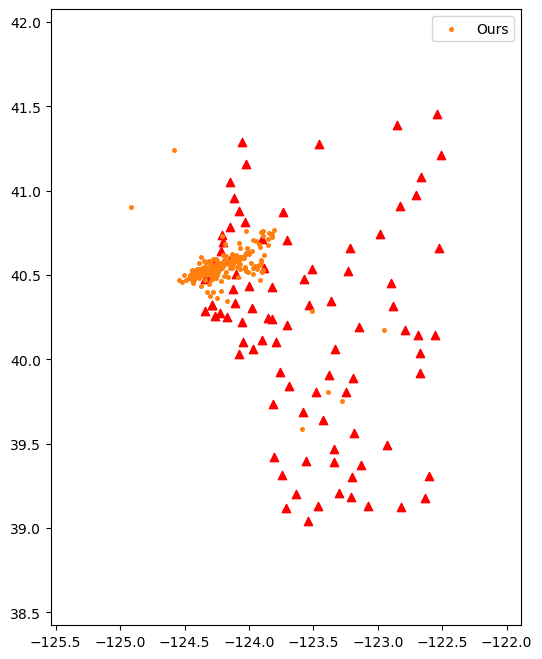

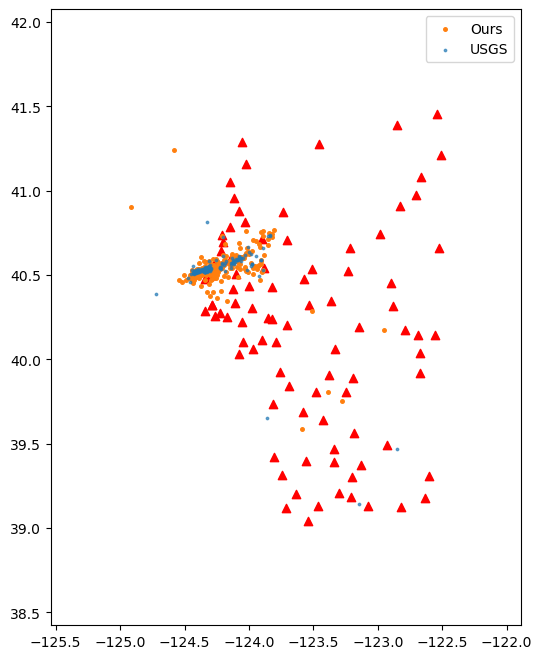

How is quality? Is it improved? In what way?


In [19]:
## Plot travel time located sources
fig, ax = plt.subplots(figsize = [8,8])
plt.scatter(locs[:,1], locs[:,0], c = 'r', marker = '^')
plt.scatter(srcs_trv[:,1], srcs_trv[:,0], c = 'C1', s = 6.5, marker = 'o', label = 'Ours')
# plt.scatter(srcs_known[:,1], srcs_known[:,0], c = 'C0', s = 4, marker = 'o', alpha = 0.8, label = 'USGS')
ax.set_aspect(1.0/np.cos(np.pi*locs[:,0].mean()/180.0)) ## Set projection aspect ratio
d_pad = 0.5 ## Pad 0.5 degrees to plot axes
ax.set_xlim(np.array(ax.get_xlim()) + np.array([-d_pad, d_pad]))
ax.set_ylim(np.array(ax.get_ylim()) + np.array([-d_pad, d_pad]))
plt.legend()
plt.show(block = False)


fig, ax = plt.subplots(figsize = [8,8])
plt.scatter(locs[:,1], locs[:,0], c = 'r', marker = '^')
plt.scatter(srcs_trv[:,1], srcs_trv[:,0], c = 'C1', s = 6.5, marker = 'o', label = 'Ours')
plt.scatter(srcs_known[:,1], srcs_known[:,0], c = 'C0', s = 3.0, marker = 'o', alpha = 0.65, label = 'USGS')
ax.set_aspect(1.0/np.cos(np.pi*locs[:,0].mean()/180.0)) ## Set projection aspect ratio
d_pad = 0.5 ## Pad 0.5 degrees to plot axes
ax.set_xlim(np.array(ax.get_xlim()) + np.array([-d_pad, d_pad]))
ax.set_ylim(np.array(ax.get_ylim()) + np.array([-d_pad, d_pad]))
plt.legend()
plt.show(block = False)
print('How is quality? Is it improved? In what way?')

# Let's now find "matched" earthquakes to the USGS events
<pre>
    (i). (i.e., events within a nearby spatial/temporal window)
    
<pre>
    (ii). Can use the "maximum_bipartite_assignment" function in GENIE.
    
<pre>
    (iii). Note: deteremining "matched" events is somewhat non-trivial (requires optimization)

In [20]:
temporal_win_match = 8.0 ## 10 s window match threshold
spatial_win_match = 30e3 ## 30 km match threshold

## First select only subset of "known" events within the time window we're processing (since we clipped the window to part of the day
ifind = np.where((srcs_known[:,3] > clip_win_start)*(srcs_known[:,3] < (clip_win_start + clip_win_duration)))[0]
srcs_known = srcs_known[ifind]
ifind_not_nan = np.where(np.isnan(srcs_trv[:,0]) == 0)[0]

matches1 = maximize_bipartite_assignment(srcs_known, srcs_refined, ftrns1, ftrns2, temporal_win = temporal_win_match, spatial_win = spatial_win_match, verbose = False)[0]
if len(ifind_not_nan) > 0:
    matches2 = maximize_bipartite_assignment(srcs_known, srcs_trv[ifind_not_nan], ftrns1, ftrns2, temporal_win = temporal_win_match, spatial_win = spatial_win_match, verbose = False)[0]
    matches2[:,1] = ifind_not_nan[matches2[:,1]]
else:
    matches2 = np.nan*np.zeros((0,2))
## matches1 and matches2 record the matched indices between USGS and detected initial events and travel time location events)

print('Matched %d events of %d USGS events'%(len(matches2), len(srcs_known)))
print('and detected %d additional new events (over %0.2f hr time interval)'%(len(srcs_trv) - len(srcs_known), clip_win_duration/3600.0))
      

Matched 70 events of 71 USGS events
and detected 249 additional new events (over 3.00 hr time interval)


# We'll now plot the matched earthquake origin time and spatial residuals

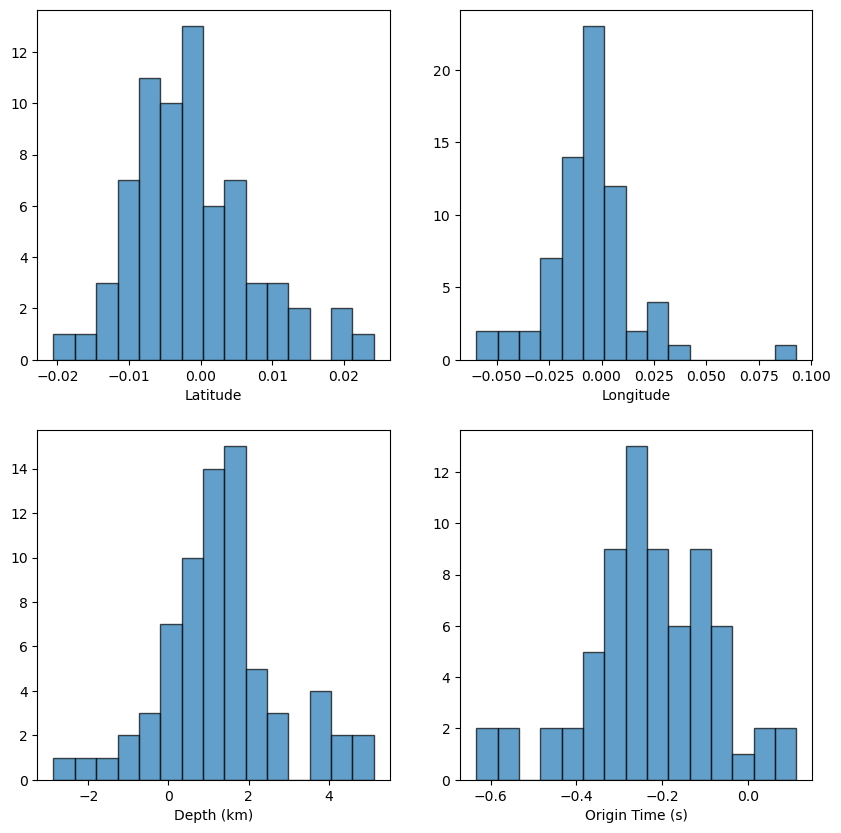

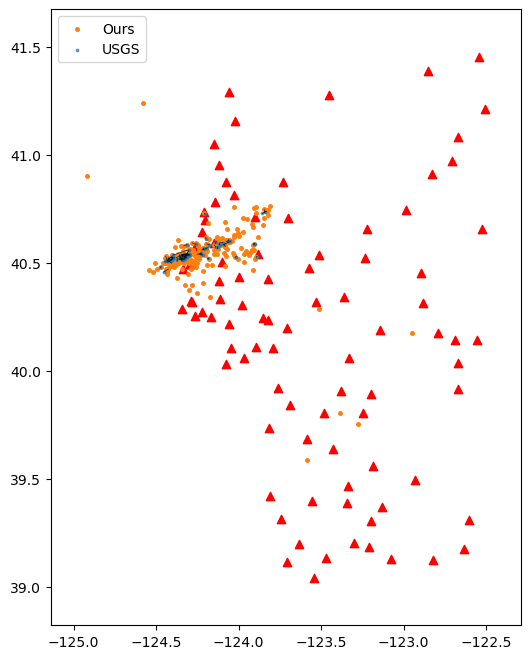

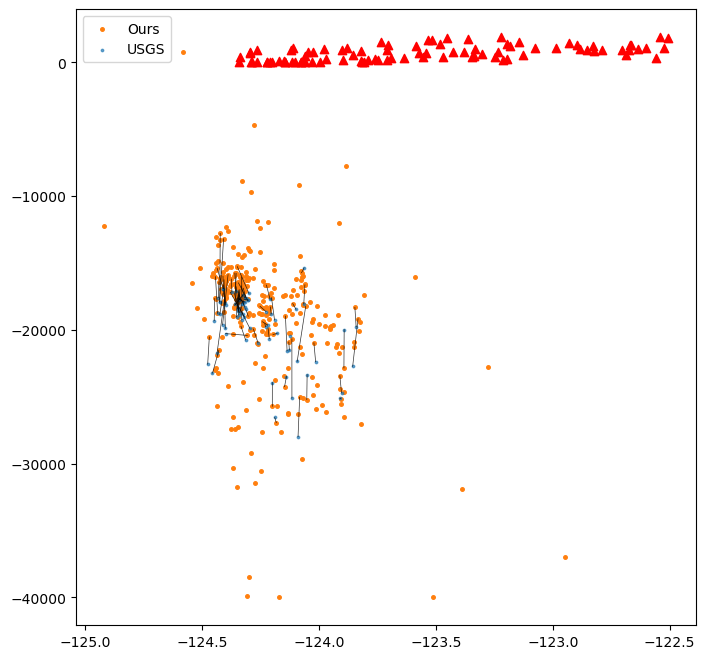

In [21]:
fig, ax = plt.subplots(2,2, figsize = [10,10])
res = srcs_trv[matches2[:,1],0:4] - srcs_known[matches2[:,0],0:4]
ax[0,0].hist(res[:,0], 15, linewidth = 1.0, alpha = 0.7, edgecolor = 'black')
ax[0,1].hist(res[:,1], 15, linewidth = 1.0, alpha = 0.7, edgecolor = 'black')
ax[1,0].hist(res[:,2]/1000.0, 15, linewidth = 1.0, alpha = 0.7, edgecolor = 'black')
ax[1,1].hist(res[:,3], 15, linewidth = 1.0, alpha = 0.7, edgecolor = 'black')
ax[0,0].set_xlabel('Latitude')
ax[0,1].set_xlabel('Longitude')
ax[1,0].set_xlabel('Depth (km)')
ax[1,1].set_xlabel('Origin Time (s)')


## Map view comparison
fig, ax = plt.subplots(figsize = [8,8])
ax.scatter(locs[:,1], locs[:,0], c = 'r', marker = '^')
ax.scatter(srcs_trv[:,1], srcs_trv[:,0], c = 'C1', s = 6.5, marker = 'o', label = 'Ours')
ax.scatter(srcs_known[:,1], srcs_known[:,0], c = 'C0', s = 3.0, marker = 'o', alpha = 0.65, label = 'USGS')
for j in range(len(matches2)):
    ax.plot([srcs_trv[matches2[j,1],1], srcs_known[matches2[j,0],1]], [srcs_trv[matches2[j,1],0], srcs_known[matches2[j,0],0]], c = 'black', alpha = 0.8, linewidth = 0.5)
# plt.plot(np.concatenate((srcs_trv[matches2[:,1],1].reshape(1,-1), srcs_known[matches2[:,0],1].reshape(1,-1)), axis = 1).T, np.concatenate((srcs_trv[matches2[:,1],0].reshape(1,-1), srcs_known[matches2[:,0],0].reshape(1,-1)), axis = 1).T, c = 'black', alpha = 0.2, linewidth = 0.5)
ax.set_aspect(1.0/np.cos(np.pi*locs[:,0].mean()/180.0)) ## Set projection aspect ratio
# d_pad = 0.5 ## Pad 0.5 degrees to plot axes
ax.set_xlim(np.array(ax.get_xlim()) + np.array([-d_pad*0.2, d_pad*0.2]))
ax.set_ylim(np.array(ax.get_ylim()) + np.array([-d_pad*0.2, d_pad*0.2]))
plt.legend()
plt.show(block = False)


## Depth view comparison
fig, ax = plt.subplots(figsize = [8,8])
ax.scatter(locs[:,1], locs[:,2], c = 'r', marker = '^')
ax.scatter(srcs_trv[:,1], srcs_trv[:,2], c = 'C1', s = 6.5, marker = 'o', label = 'Ours')
ax.scatter(srcs_known[:,1], srcs_known[:,2], c = 'C0', s = 3.0, marker = 'o', alpha = 0.65, label = 'USGS')
for j in range(len(matches2)):
    ax.plot([srcs_trv[matches2[j,1],1], srcs_known[matches2[j,0],1]], [srcs_trv[matches2[j,1],2], srcs_known[matches2[j,0],2]], c = 'black', alpha = 0.8, linewidth = 0.5)
# plt.plot(np.concatenate((srcs_trv[matches2[:,1],1].reshape(1,-1), srcs_known[matches2[:,0],1].reshape(1,-1)), axis = 1).T, np.concatenate((srcs_trv[matches2[:,1],0].reshape(1,-1), srcs_known[matches2[:,0],0].reshape(1,-1)), axis = 1).T, c = 'black', alpha = 0.2, linewidth = 0.5)
# ax.set_aspect(1.0/np.cos(np.pi*locs[:,0].mean()/180.0)) ## Set projection aspect ratio
# d_pad = 0.5 ## Pad 0.5 degrees to plot axes
# ax.set_xlim(np.array(ax.get_xlim()) + np.array([-d_pad*0.2, d_pad*0.2]))
# ax.set_ylim(np.array(ax.get_ylim()) + np.array([-d_pad*0.2, d_pad*0.2]))
plt.legend()
plt.show(block = False)

# r = srcs_trv[matches2[:,1],0:4] - srcs_known[matches2[:,0],0:4]
# print(r.max(0))



# Compute magnitudes

In [28]:
# Let's calibrate a magnitude scale between our events and matched USGS events
# Use relationship log_amp = C1*Mag - C2*log_dist + C_i

Matches = np.copy(matches2)
srcs_w = srcs[:,4]
min_threshold = 0.0
srcs_ref = np.copy(srcs_known)

## Setup probability of sampling different matched events
prob = np.ones(len(Matches))
for i in range(len(Matches)):
	if (cnt_p[Matches[i,1]] == 0) or (cnt_s[Matches[i,1]] == 0): ## Skip events missing all of p or s (otherwise might have an indexing issue)
		prob[i] = 0.0
	if srcs_w[Matches[i,1]] < min_threshold:
		prob[i] = 0.0
	if (cnt_p[Matches[i,1]] + cnt_s[Matches[i,1]]) < min_picks:
		prob[i] = 0.0

## Fit magnitude model

prob = prob/prob.sum()
print('Retained %0.8f of matches'%(len(np.where(prob > 0)[0])/len(Matches)))

# ## Setup spatial graph and create laplacian
# k_spc_edges = 25 # 50 ## smooth the spatial coefficients
# x_grid = x_grids[0]
# A_src_src = knn(torch.Tensor(ftrns1(x_grid)/1000.0), torch.Tensor(ftrns1(x_grid)/1000.0), k = k_spc_edges + 1).flip(0).long().contiguous().to(device) # )[0]
# lap = get_laplacian(A_src_src, normalization = 'rw')

# ## Initilize Laplace classes
# k_interp = 15
# Lap = Laplacian(lap[0], lap[1])
# # Interp = InterpolateAnisotropicStations(k = k_interp, device = device)

use_scalar_station_corrections = True
if use_scalar_station_corrections == True:
	mag_grid = locs.mean(0).reshape(1,-1)
	k_grid = 1
else:
	n_mag_grid = 30
	mag_grid = kmeans_packing_sampling_points(scale_x_extend, offset_x_extend, 3, n_mag_grid, ftrns1, n_batch = 3000, n_steps = 3000, n_sim = 1)[0]
	k_grid = 5

Mag = Magnitude(torch.Tensor(locs).to(device), torch.Tensor(mag_grid).to(device), ftrns1_diff, ftrns2_diff, k = k_grid, device = device).to(device)

optimizer = optim.Adam(Mag.parameters(), lr = 0.01)
schedular = StepLR(optimizer, 1000, gamma = 0.8)
loss_func = nn.MSELoss()


n_updates = 1500
n_batch = 100
use_difference_loss = True
iuse_p = np.where([len(Picks_P[i]) >= 2 for i in range(len(Picks_P))])[0]
iuse_s = np.where([len(Picks_S[i]) >= 2 for i in range(len(Picks_S))])[0]

## Applying fitting
losses = []
for i in range(n_updates):

	optimizer.zero_grad()

	i0 = np.random.choice(len(Matches), size = n_batch, p = prob)

	ref_ind, srcs_ind = Matches[i0,0], Matches[i0,1]

	arv_p = torch.Tensor(np.hstack([Picks_P[j][:,0].astype('int') for j in srcs_ind])).to(device)
	arv_s = torch.Tensor(np.hstack([Picks_S[j][:,0].astype('int') for j in srcs_ind])).to(device)
	amp_p = torch.Tensor(np.hstack([Picks_P[j][:,2] for j in srcs_ind])).to(device)
	amp_s = torch.Tensor(np.hstack([Picks_S[j][:,2] for j in srcs_ind])).to(device)
	num_p = np.array([len(Picks_P[j]) for j in srcs_ind])
	num_s = np.array([len(Picks_S[j]) for j in srcs_ind])
	ind_p = np.hstack([Picks_P[j][:,1].astype('int') for j in srcs_ind])
	ind_s = np.hstack([Picks_S[j][:,1].astype('int') for j in srcs_ind])

	cat_slice_single = torch.Tensor(np.concatenate((srcs[srcs_ind,0:3], srcs_ref[ref_ind,4].reshape(-1,1)), axis = 1)).to(device) # .repeat_interleave(torch.Tensor(num_p).to(device).long(), dim = 0)

	cat_slice_p = torch.Tensor(cat_slice_single).to(device).repeat_interleave(torch.Tensor(num_p).to(device).long(), dim = 0)
	cat_slice_s = torch.Tensor(cat_slice_single).to(device).repeat_interleave(torch.Tensor(num_s).to(device).long(), dim = 0)


	log_amp_p = Mag.train(torch.Tensor(ind_p).long().to(device), cat_slice_p[:,0:3], cat_slice_p[:,3], torch.zeros(len(ind_p)).long().to(device))
	log_amp_s = Mag.train(torch.Tensor(ind_s).long().to(device), cat_slice_s[:,0:3], cat_slice_s[:,3], torch.ones(len(ind_s)).long().to(device))

	loss1 = loss_func(torch.log10(amp_p), log_amp_p)
	loss2 = loss_func(torch.log10(amp_s), log_amp_s)
	loss = 0.5*loss1 + 0.5*loss2

	if use_difference_loss == True: ## If True, also compute pairwise log_amplitude differences (for different stations, and fixed sources), since
		## these cancel out the effect of the magnitude; and hence, this provides an unsupervised target to constrain the amplitude-distance
		## attenuation relationships (i.e., Trugman, 2024; SRL: A High‐Precision Earthquake Catalog for Nevada).
		ichoose_p = np.random.choice(iuse_p, size = int(n_batch/2))
		ichoose_s = np.random.choice(iuse_s, size = int(n_batch/2))
		ichoose_p1 = [np.random.choice(len(Picks_P[ichoose_p[j]]), size = 2, replace = False) for j in range(len(ichoose_p))]
		ichoose_s1 = [np.random.choice(len(Picks_S[ichoose_s[j]]), size = 2, replace = False) for j in range(len(ichoose_s))]
		
		ind_p1, ind_p2 = np.array([Picks_P[ichoose_p[j]][ichoose_p1[j][0],1] for j in range(len(ichoose_p))]), np.array([Picks_P[ichoose_p[j]][ichoose_p1[j][1],1] for j in range(len(ichoose_p))])
		amp_p1, amp_p2 = np.array([Picks_P[ichoose_p[j]][ichoose_p1[j][0],2] for j in range(len(ichoose_p))]), np.array([Picks_P[ichoose_p[j]][ichoose_p1[j][1],2] for j in range(len(ichoose_p))])

		ind_s1, ind_s2 = np.array([Picks_S[ichoose_s[j]][ichoose_s1[j][0],1] for j in range(len(ichoose_s))]), np.array([Picks_S[ichoose_s[j]][ichoose_s1[j][1],1] for j in range(len(ichoose_s))])
		amp_s1, amp_s2 = np.array([Picks_S[ichoose_s[j]][ichoose_s1[j][0],2] for j in range(len(ichoose_s))]), np.array([Picks_S[ichoose_s[j]][ichoose_s1[j][1],2] for j in range(len(ichoose_s))])

		## Differential P amplitude loss
		log_amp_p1 = Mag.train(torch.Tensor(ind_p1).long().to(device), torch.Tensor(srcs[ichoose_p,0:3]).to(device), torch.ones(len(ichoose_p)).to(device), torch.zeros(len(ind_p1)).long().to(device)) ## Note: effect of magnitude  will be canceled out
		log_amp_p2 = Mag.train(torch.Tensor(ind_p2).long().to(device), torch.Tensor(srcs[ichoose_p,0:3]).to(device), torch.ones(len(ichoose_p)).to(device), torch.zeros(len(ind_p2)).long().to(device)) ## Note: effect of magnitude  will be canceled out
		log_amp_p_diff = log_amp_p1 - log_amp_p2
		trgt_amp_p_diff = torch.Tensor(np.log10(amp_p1) - np.log10(amp_p2)).to(device)
		loss_diff_p = loss_func(log_amp_p_diff, trgt_amp_p_diff)

		## Differential S amplitude loss
		log_amp_s1 = Mag.train(torch.Tensor(ind_s1).long().to(device), torch.Tensor(srcs[ichoose_s,0:3]).to(device), torch.ones(len(ichoose_s)).to(device), torch.ones(len(ind_s1)).long().to(device)) ## Note: effect of magnitude  will be canceled out
		log_amp_s2 = Mag.train(torch.Tensor(ind_s2).long().to(device), torch.Tensor(srcs[ichoose_s,0:3]).to(device), torch.ones(len(ichoose_s)).to(device), torch.ones(len(ind_s2)).long().to(device)) ## Note: effect of magnitude  will be canceled out
		log_amp_s_diff = log_amp_s1 - log_amp_s2
		trgt_amp_s_diff = torch.Tensor(np.log10(amp_s1) - np.log10(amp_s2)).to(device)
		loss_diff_s = loss_func(log_amp_s_diff, trgt_amp_s_diff)

		loss_diff = 0.5*loss_diff_p + 0.5*loss_diff_s

		## Take the mean loss
		loss = 0.5*loss + 0.5*loss_diff


	loss.backward()
	optimizer.step()
	schedular.step()
	losses.append(loss.item())
    # if np.mod(i, 5) == 0:
    # print('%d %0.5f'%(i, loss.item()))

	assert(torch.abs(log_amp_p).max().item() < 100)
	assert(torch.abs(log_amp_s).max().item() < 100)

Retained 1.00000000 of matches


In [30]:
# Compute magnitudes
Mag_pred = []
for i in range(len(srcs_trv)):

    ind_p, log_amp_p = Picks_P[i][:,1].astype('int'), np.log10(Picks_P[i][:,2])
    ind_s, log_amp_s = Picks_S[i][:,1].astype('int'), np.log10(Picks_S[i][:,2])

    mag_p = Mag(torch.Tensor(ind_p).long().to(device), torch.Tensor(srcs[i,0:3].reshape(1,-1)).to(device), torch.Tensor(log_amp_p).to(device), torch.zeros(len(ind_p)).long().to(device))
    mag_s = Mag(torch.Tensor(ind_s).long().to(device), torch.Tensor(srcs[i,0:3].reshape(1,-1)).to(device), torch.Tensor(log_amp_s).to(device), torch.ones(len(ind_s)).long().to(device))

    mag_pred = np.median(np.concatenate((mag_p.cpu().detach().numpy().reshape(-1), mag_s.cpu().detach().numpy().reshape(-1)), axis = 0))
    Mag_pred.append(mag_pred)
    if np.mod(i, 50) == 0:
        print(i)

mag_pred = np.hstack(Mag_pred)

0
50
100
150
200
250
300


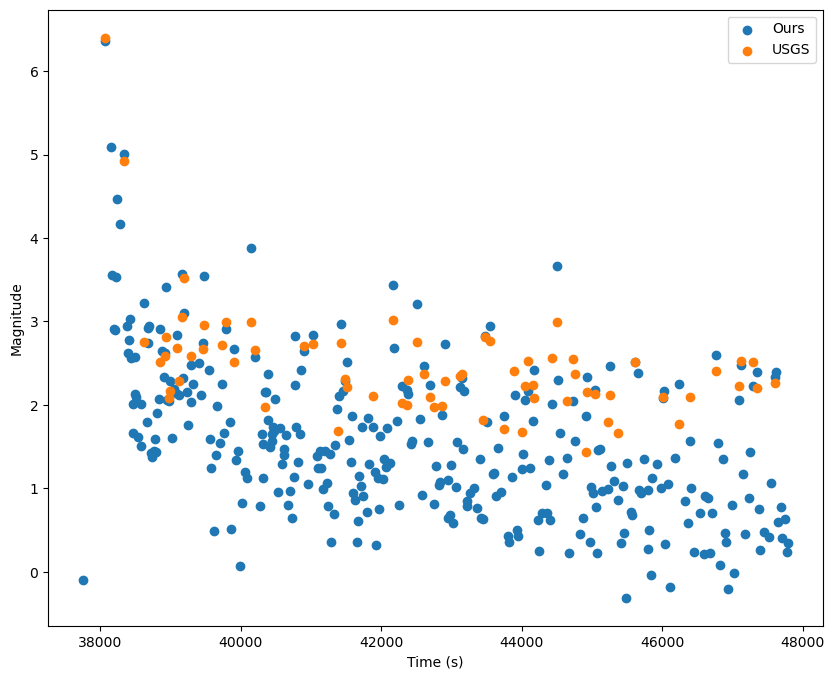

In [31]:
# Plot magnitudes
fig, ax = plt.subplots(figsize = [10,8])
ax.scatter(srcs_trv[:,3], mag_pred, c = 'C0', label = 'Ours')
ax.scatter(srcs_known[:,3], srcs_known[:,4], c = 'C1', label = 'USGS')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Magnitude')
plt.legend()

# Write catalog file to HypoDD format

In [41]:
os.chdir('/home/jovyan/')

mags = np.copy(mag_pred)

min_assoc_val = min([np.array([Picks_P[j][:,-1].min(), Picks_S[j][:,-1].min()]).min() for j in range(len(Picks_P))])
max_assoc_val = max([np.array([Picks_P[j][:,-1].max(), Picks_S[j][:,-1].max()]).max() for j in range(len(Picks_P))])

max_assoc_val = max([1.0, max_assoc_val])
pval = np.polyfit([min_assoc_val, max_assoc_val], [0.5, 1.0], 1)
pmap = lambda x: np.polyval(pval, x)

trv_out1 = trv(torch.Tensor(locs_use).to(device), torch.Tensor(srcs_refined[:,0:3]).to(device)).cpu().detach().numpy() + srcs_refined[:,3].reshape(-1,1,1)
trv_out1_all = trv(torch.Tensor(locs).to(device), torch.Tensor(srcs_refined[:,0:3]).to(device)).cpu().detach().numpy() + srcs_refined[:,3].reshape(-1,1,1) 
# trv_out2 = trv(torch.Tensor(locs_use), torch.Tensor(srcs_trv[:,0:3])).cpu().detach().numpy() + srcs_trv[:,3].reshape(-1,1,1) 

trv_out2 = np.nan*np.zeros((srcs_trv.shape[0], locs_use.shape[0], 2))
trv_out2_all = np.nan*np.zeros((srcs_trv.shape[0], locs.shape[0], 2))
ifind_not_nan = np.where(np.isnan(srcs_trv[:,0]) == 0)[0]
if len(ifind_not_nan) > 0:
    trv_out2[ifind_not_nan,:,:] = trv(torch.Tensor(locs_use).to(device), torch.Tensor(srcs_trv[ifind_not_nan,0:3]).to(device)).cpu().detach().numpy() + srcs_trv[ifind_not_nan,3].reshape(-1,1,1)
    trv_out2_all[ifind_not_nan,:,:] = trv(torch.Tensor(locs).to(device), torch.Tensor(srcs_trv[ifind_not_nan,0:3]).to(device)).cpu().detach().numpy() + srcs_trv[ifind_not_nan,3].reshape(-1,1,1)
    

res_p = [trv_out2[j,Picks_P[j][:,1].astype('int'),0] - Picks_P[j][:,0] for j in range(len(srcs_trv))]
res_s = [trv_out2[j,Picks_S[j][:,1].astype('int'),1] - Picks_S[j][:,0] for j in range(len(srcs_trv))]
rms = np.array([np.linalg.norm(np.concatenate((res_p[j], res_s[j]), axis = 0))/np.sqrt(len(res_p[j]) + len(res_s[j])) for j in range(len(srcs_trv))])


# ph2dt accepts hypocenter, followed by its travel time data in the following format:
#, YR, MO, DY, HR, MN, SC, LAT, LON, DEP, MAG, EH, EZ, RMS, ID

f = open(path_to_file + 'ph2dt_file_12_20_22.txt', 'w')
for i in range(len(srcs_trv)):

	t0 = UTCDateTime(date[0], date[1], date[2]) + srcs_trv[i,3]
	sec_res = t0 - UTCDateTime(t0.year, t0.month, t0.day, t0.hour, t0.minute, t0.second)

	f.write('# %d %d %d %d %d %0.3f %0.4f %0.4f %0.3f %0.3f %0.3f %0.3f %0.3f %d \n'%(t0.year, t0.month, t0.day, t0.hour, t0.minute, t0.second + sec_res, srcs_trv[i,0], srcs_trv[i,1], -1.0*srcs_trv[i,2]/1000.0, mags[i], uncertainity[i]/1000.0, uncertainity[i]/1000.0, rms[i], i + 1))

	for j in range(len(Picks_P[i])):
		f.write('%s %0.3f %0.2f %s \n'%(stas[int(Picks_P[i][j,1])], Picks_P[i][j,0] - srcs_trv[i,3], pmap(Picks_P[i][j,-1]), 'P'))

	for j in range(len(Picks_S[i])):
		f.write('%s %0.3f %0.2f %s \n'%(stas[int(Picks_S[i][j,1])], Picks_S[i][j,0] - srcs_trv[i,3], pmap(Picks_S[i][j,-1]), 'S'))

f.close()

print('Saved file')

IndexError: index 77 is out of bounds for axis 1 with size 77

In [43]:
[trv_out2[j,Picks_P[j][:,1].astype('int'),0] - Picks_P[j][:,0] for j in range(len(srcs_trv))]

IndexError: index 77 is out of bounds for axis 1 with size 77